## Writing a general TMM solver
Have to solve a full ass matrix equation, but it's only 4x4, so that should be nice.

In [1]:
# %load ../TMM_functions/eigen_modes.py
'''
functions which analyzes the eigenmodes of a medium
'''

import numpy as np
import scipy.linalg as LA

def eigen_W(Gamma_squared):
    '''
    for the E_field
    use: you would only really want to use this if the media is anisotropic in any way
    :param Gamma: matrix for the scattering formalism
    :return:
    '''
    #could be an issue with how eig sorts eigenvalues in the output
    Lambda, W = np.linalg.eig(Gamma_squared);  # LAMBDa is effectively refractive index
    lambda_squared_matrix = np.diag(Lambda);
    lambda_matrix = np.sqrt(lambda_squared_matrix.astype('complex'));
    return W, lambda_matrix

def eigen_V(Q, W, lambda_matrix):
    #V = Q*W*(lambda)^-1
    '''
    eigenmodes for the i*eta*H field
    :param Q: Q matrix
    :param W: modes from eigen W
    :param lambda_matrix: eigen values from W
    :return:
    '''
    return Q@W@np.linalg.inv(lambda_matrix);

In [79]:
import sys
sys.path.append('../')
from TMM_functions import PQ_matrices as pq
from TMM_functions import scatter_matrices as sm
from TMM_functions import redheffer_star as rs
from TMM_functions import generate_initial_conditions as ic
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy import linalg as LA
from numpy.linalg import solve as bslash
import time
from math import cos,sin,tan
from convolution_matrices.convmat1D import *
import pdb
# from RCWA_1D_functions.grating_fft.grating_conv import *

def nonHermitianEigenSorter(eigenvalues): ### 
    N = len(eigenvalues);
    sorted_indices=[];
    sorted_eigs = [];
    for i in range(N):
        eig = eigenvalues[i];
        if(np.real(eig)>0 and np.imag(eig) == 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)==0 and np.imag(eig) > 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)>0 and abs(np.imag(eig)) > 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
    return sorted_eigs, sorted_indices;

# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
'''
L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;

n_ridge = 3.48;              # ridge
n_groove = 3.48;                # groove (unit-less)
lattice_constant = 0.7;  # SI units

## simulation parameters
theta = (80)*np.pi/180;
phi = (0)*np.pi/180;
e_r = 1;
m_r = 1;
e_t = 1;
m_t = 1;
n_i = np.sqrt(e_r);

normal_vector= [0,0,-1]

# epsilon_tensor = np.array([[12,1,0],[0,2,0],[1,0,12]]);
# epsilon_tensor = np.array([[12,0,10],[0,12,0],[10,0,12]]);
# epsilon_tensor = np.array([[12,0,0],[0,10,0],[0,0,8]]);
# epsilon_tensor = np.array([[12,0,0],[0,12,0],[0,0,12]]);
# epsilon_tensor = np.array([[9,0,0],[0,9,0],[0,0,9]]);
# epsilon_tensor = np.array([[9,0,10],[0,9,0],[10,0,9]]);

epsilon_tensor = np.array([[12,5,0],[5,12,0],[0,0,12]]);
epsilon_tensor = np.array([[12,0,10],[0,12,0],[10,0,12]]);
#epsilon_tensor = np.array([[12,0,0],[0,12,0],[0,0,12]]);

# epsilon_tensor = np.array([[12,0,10],[0,12,10],[10,10,12]]);
## if the exy eyx term is equal to exx eyy, then there is a degeneracy which you have to account for.

mu_tensor = np.array([[1,0,0],[0,1,0],[0,0,1]])
I = np.matrix(np.eye(2))

## specify the initial kx and ky
k0=1
kx = k0 *np.sin(theta)*np.cos(phi);
ky = k0 *np.sin(theta)*np.sin(phi);
print(kx, ky)

0.984807753012208 0.0


In [80]:
import pandas as pd
from IPython.display import display
def show(data):
#     df=pd.DataFrame(data)
    df=pd.DataFrame(np.around(data,3))
    display(df)

In [81]:
## =================  specify gap media ========================##
e_h = 1; m_h = 1;
# Pg, Qg, kzg = pq.P_Q_kz(kx, ky, e_h, m_h)
# Wg = I;  # Wg should be the eigenmodes of the E field, which paparently is the identity, yes for a homogeneous medium
# sqrt_lambda = cmath.sqrt(-1) * Wg;
# # remember Vg is really Qg*(Omg)^-1; Vg is the eigenmodes of the H fields
# Vg = Qg * Wg * (sqrt_lambda) ** -1;
# print(Wg, type(Vg))

In [82]:
#ampltidue of the te vs tm modes (which are decoupled)
pte = 0; #1/np.sqrt(2);
ptm = 1; #cmath.sqrt(-1)/np.sqrt(2);
polarization_amplitudes = [pte, ptm]
## we can specify this...but note there is no differentation of these after we go through an anisotropic layer

## two options:
We either write it as a second order equation with first order terms or we solve the whole thing.

Solving the whole thing appears to be simpler, but we should note a few things. The biggest thing is that the modes for $W$ are not an identity matrix, which is what we typically assume, even for an isotropic medium.

## debugging
Somehow, even in the TMM formulation, I have an issue with energy conservation as soon as anisotropy is ADDED. Adding anisotropy splits the degeneracy founded in the isotropic version of the problem.


if the exy eyx term is equal to exx eyy, then there is a degeneracy which you have to account for.

In [83]:
def Amat(kxx,kyy,epsilon_tensor,mu_tensor):
    a11 = -1j*(kyy*mu_tensor[1,2]/mu_tensor[2,2] + kxx*(epsilon_tensor[2,0]/epsilon_tensor[2,2]))
    a12 = 1j*kxx*(mu_tensor[1,2]/mu_tensor[2,2] - epsilon_tensor[2,1]/epsilon_tensor[2,2]);
    a13 = kxx*kyy/epsilon_tensor[2,2] + mu_tensor[1,0] - mu_tensor[1,2]*mu_tensor[2,0]/mu_tensor[2,2];
    a14 = -kxx**2/epsilon_tensor[2,2] + mu_tensor[1,1]-  mu_tensor[1,2]*mu_tensor[2,1]/mu_tensor[2,2];

    a21 = 1j* kyy *(mu_tensor[0,2]/mu_tensor[2,2] - epsilon_tensor[2,0]/epsilon_tensor[2,2]);
    a22 = -1j * (kxx*mu_tensor[0,2]/mu_tensor[2,2] + kyy*epsilon_tensor[2,1]/epsilon_tensor[2,2]);
    a23 = kyy**2/epsilon_tensor[2,2] - mu_tensor[0,0] +  mu_tensor[0,2]*mu_tensor[2,0]/mu_tensor[2,2];
    a24 =  -kxx*kyy/epsilon_tensor[2,2] - mu_tensor[0,1] + mu_tensor[0,2]*mu_tensor[2,1]/mu_tensor[2,2];

    a31 = kxx*kyy/mu_tensor[2,2] + epsilon_tensor[1,0] - epsilon_tensor[1,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2]
    a32 = -kxx**2/mu_tensor[2,2] +epsilon_tensor[1,1] - epsilon_tensor[1,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2];
    a33 = -1j*(kyy*epsilon_tensor[1,2]/epsilon_tensor[2,2] + kxx*(mu_tensor[2,0]/mu_tensor[2,2]));
    a34 = 1j*kxx*(epsilon_tensor[1,2]/epsilon_tensor[2,2] - mu_tensor[2,1]/mu_tensor[2,2] )

    a41 = kyy**2/mu_tensor[2,2] - epsilon_tensor[0,0] +  epsilon_tensor[0,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2];
    a42 = -kxx*kyy/mu_tensor[2,2] - epsilon_tensor[0,1] + epsilon_tensor[0,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2];
    a43 = 1j*kyy*(epsilon_tensor[0,2]/epsilon_tensor[2,2]-mu_tensor[2,0]/mu_tensor[2,2] );
    a44 = -1j*(kxx*epsilon_tensor[0,2]/epsilon_tensor[2,2] + kyy*mu_tensor[2,1]/mu_tensor[2,2]);
    A = np.matrix([[a11, a12, a13, a14],
                  [a21, a22, a23, a24],
                  [a31, a32, a33, a34],
                  [a41, a42, a43, a44]]);
    return A


In [84]:
ref = []; ref0 = [];
trans = []; trans0 = [];
# wvlen_scan = np.linspace(2.55, 4, 1);
freqs = np.linspace(0.5,1,20)
# wvlen_scan = np.linspace(2.55, 4, 1);
wvlen_scan = 1/freqs;
thickness = 0.5; # 1 layer

num_pts = 5
kxs = np.linspace(0,0.15,num_pts)
kys = np.linspace(0,0.15,num_pts)
kxs,kys = np.meshgrid(kxs,kys)
kxs = kxs.flatten()
kys = kys.flatten()

phis = np.arctan(kys/(kxs+1e-9))
# kzs = np.sqrt(freqs[0]**2 - kxs**2 - kys**2)
thetas = np.arcsin(np.sqrt(kxs**2 + kys**2) / freqs[0])

for wvlen in wvlen_scan:
    k0 = 2*np.pi/wvlen;
    for ki in range(len(thetas)):
        theta = thetas[ki] 
#         theta = 0
        phi = phis[ki]
#         phi=0
        kx = np.sin(theta)*np.cos(phi);
        ky = np.sin(theta)*np.sin(phi);
        scale=1
        kxx=kx*scale
        kyy=ky*scale
        print('\nkx,ky',kxx,kyy)
        A = Amat(kxx,kyy,epsilon_tensor,mu_tensor)
    
        display(np.around(A,5))
        
        
        print(np.linalg.cond(A))
        eigenvals, eigenmodes = np.linalg.eig(A);
#         rounded_eigenvals = np.round(eigenvals, 3)


        #print(np.round(eigenvals,3)); print(np.round(eigenmodes,3))

        ## suppose we directly diagonalize this matrix.


        ## we need to siphon off the forward propagating modes.
        sorted_eigs, sorted_inds = nonHermitianEigenSorter(np.round(eigenvals,10));
#         print(len(sorted_eigs))
#         print(eigenvals.shape,'shape')
#         sorted_eigs = eigenvals[:2]
#         sorted_inds = np.arange(len(sorted_eigs))

    #     sorted_inds = [1,3];
    #     sorted_eigs = eigenvals[sorted_inds];
        #print(sorted_eigs) ## since we have Ey, Ex, Hy, Hx, on a uniform slab, there is a 2-fold degeneracy 

    #     plt.plot(np.real(rounded_eigenvals), np.imag(rounded_eigenvals), 'o')
    #     plt.plot(np.real(sorted_eigs), np.imag(sorted_eigs), '.r')
    #     plt.show()

        Pg, Qg, kzg = pq.P_Q_kz(kx, ky, e_h, m_h)
        Wg = I;  # Wg should be the eigenmodes of the E field, which paparently is the identity, yes for a homogeneous medium
        sqrt_lambda = cmath.sqrt(-1) * Wg;
        Vg = Qg * Wg * (sqrt_lambda) ** -1;

        ## ========================================================
        W_i = eigenmodes[0:2, sorted_inds];
        V_i = eigenmodes[2:, sorted_inds];
        Om =  np.matrix(np.diag(sorted_eigs) );
        show(eigenmodes)
        print(eigenvals)
        print('w',np.round(W_i,3),'\nv', np.round(V_i,3),'\nOm', np.round(Om,3))

        #then what... match boundary conditions... try using the gaylord formulation.
        # or use the scattering matrix formalism, where we still, technically deal with all field components...

        Sg11 = np.matrix(np.zeros((2, 2))); Sg12 = np.matrix(np.eye(2, 2));
        Sg21 = np.matrix(np.eye(2, 2)); Sg22 = np.matrix(np.zeros((2, 2)));  # matrices
        Sg = np.block([[Sg11, Sg12], [Sg21, Sg22]]);  # initialization is equivelant as that for S_reflection side matrix

        ### ================= Working on the Reflection Side =========== ##
        Pr, Qr, kzr = pq.P_Q_kz(kx, ky, e_r, m_r)

        ## ============== values to keep track of =======================##
        S_matrices = list();
        kz_storage = [kzr];
        X_storage = list();
        ## ==============================================================##

        # define vacuum wavevector k0
        lam0 = wvlen;  # k0 and lam0 are related by 2*pi/lam0 = k0
        k0 = 2*np.pi/lam0;
        ## modes of the layer
        Om_r = np.matrix(cmath.sqrt(-1) * kzr * I);
        X_storage.append(Om_r);
        W_ref = I;
        V_ref = Qr * Om_r.I;  # can't play games with V like with W because matrices for V are complex
        #print(Om_r)
        ## calculating A and B matrices for scattering matrix
        Ar, Br = sm.A_B_matrices(W_ref, Wg, V_ref, Vg);

        S_ref, Sr_dict = sm.S_R(Ar, Br);  # scatter matrix for the reflection region
        S_matrices.append(S_ref);
        Sg, D_r, F_r = rs.RedhefferStar(Sg, S_ref);

        # longitudinal k_vector
        ## ============ WORKING INSIDE ANISOTROPIC LAYER ================#
        # now defIne A and B
#         A, B = sm.A_B_matrices(Wg, W_i, Vg, V_i);
#         W_i /= np.sqrt(np.linalg.det(W_i))
#         V_i /= np.sqrt(np.linalg.det(V_i))
        A, B = sm.A_B_matrices(W_i, Wg, V_i, Vg);
        print('A',A,'\nB',B)
#         pdb.set_trace()
        
        # calculate scattering matrix
        S_layer, Sl_dict = sm.S_layer(A, B, thickness, k0*scale, Om)
        S_matrices.append(S_layer);

        ## update global scattering matrix using redheffer star
        Sg, D_i, F_i = rs.RedhefferStar(Sg, S_layer);

        ##========= Working on the Transmission Side==============##
        Pt, Qt, kz_trans = pq.P_Q_kz(kx, ky, e_t, m_t);
        kz_storage.append(kz_trans);

        Omt = cmath.sqrt(-1) * kz_trans * I;
        Vt = Qt * np.linalg.inv(Omt);

        # get At, Bt
        At, Bt = sm.A_B_matrices(I, Wg, Vt, Vg)

        ST, ST_dict = sm.S_T(At, Bt)
        S_matrices.append(ST);
        # update global scattering matrix
        Sg, D_t, F_t = rs.RedhefferStar(Sg, ST);

        K_inc_vector = n_i * k0 * np.matrix([np.sin(theta) * np.cos(phi), \
                                             np.sin(theta) * np.sin(phi), np.cos(theta)]);

        # cinc is the c1+
        E_inc, cinc, Polarization = ic.initial_conditions(K_inc_vector, theta, normal_vector, pte, ptm)

        ## COMPUTE FIELDS
        Er = Sg[0:2, 0:2] * cinc;  # S11; #(cinc = initial mode amplitudes), cout = Sg*cinc; #2d because Ex, Ey...
        Et = Sg[2:, 0:2] * cinc;  # S21

        Er = np.squeeze(np.asarray(Er));
        Et = np.squeeze(np.asarray(Et));

        Erx = Er[0];  Ery = Er[1]; Etx = Et[0]; Ety = Et[1];

        # apply the grad(E) = 0 equation to get z components, this equation comes out of the longitudinal equation 
        # or the divergence equation and is valid since the transmission region is VACUUM (as is the reflection region)
        Erz = -(kx * Erx + ky * Ery) / kzr;
        Etz = -(kx * Etx + ky * Ety) / kz_trans;  ## using divergence of E equation here

    #     Erz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Erx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ery) / kzr/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);
    #     Etz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Etx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ety) / kz_trans/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);  ## using divergence of E equation here
    #     Erz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kzr) * Erx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kzr)* Ery) /(epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kzr);
    #     Etz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kz_trans) * Etx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kz_trans)* Ety) / (epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kz_trans);  ## using divergence of E equation here

#         print(kx,ky,kzr,kz_trans)

        # add in the Erz component to vectors
        Er = np.matrix([Erx, Ery, Erz]);  # a vector
        Et = np.matrix([Etx, Ety, Etz]);
#         print(E_inc)

        R = np.linalg.norm(Er) ** 2;
        T = np.linalg.norm(Et) ** 2;
#         ref.append(R);
#         trans.append(T);
#         ref.append(np.abs(Erz));
#         trans.append(np.abs(Etz));
        print('R+T',np.around(np.sum(R)+np.sum(T),2))
        ref.append([Erx,Ery,Erz]);
        trans.append([Etx,Ety,Etz]);
        
        ref0.append(np.sum(R))
        trans0.append(np.sum(T))


kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.01

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.01

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.01

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.0

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.01

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.01

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.01

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.01

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.01

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.01

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.02

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.02

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.01

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.0

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.0

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.0

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.0

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.0

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.01

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.0

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.0

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.01

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.01

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.01

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 0.99

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 0.99

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 0.99

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 0.99

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 0.99

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 0.99

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 0.99

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 0.99

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 0.99

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 0.99

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 0.99

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 0.98

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 0.99

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 0.99

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 0.99

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 0.98

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 0.98

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 0.98

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 0.99

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 0.98

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 0.98

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 0.98

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 0.97

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 0.99

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 0.98

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 0.98

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 0.97

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 0.97

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 0.99

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 0.99

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 0.99

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 0.99

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 0.99

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 0.99

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 0.99

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 0.99

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 0.99

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 0.99

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 0.99

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 0.99

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 0.99

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.0

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.0

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.0

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.0

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.0

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.0

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.01

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.01

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.0

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.01

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.01

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.02

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.0

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.01

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.01

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.01

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.0

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.01

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.01

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.02

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.01

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.02

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.02

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.03

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.0

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.01

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.01

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.01

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.01

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.01

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.02

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.02

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.01

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.02

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.02

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.03

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.0

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.01

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.01

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.01

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.0

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.01

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.01

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.02

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.01

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.01

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.02

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.03

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.0

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.0

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.0

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.01

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.0

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.01

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.01

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.01

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.0

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.01

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.01

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.02

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.0

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.0

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.0

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.0

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.0

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.0

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.0

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.01

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.0

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.0

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.01

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.01

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 0.99

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 0.99

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.0

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.0

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 0.99

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 0.99

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.0

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.0

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 0.99

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 0.99

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.0

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 0.99

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 0.99

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 0.99

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 0.99

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 0.99

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 0.99

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 0.99

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 0.98

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 0.98

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 0.99

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 0.99

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 0.98

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 0.98

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 0.98

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 0.98

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 0.99

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 0.99

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 0.99

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 0.98

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 0.98

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 0.98

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 0.98

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 0.99

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 0.97

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 0.97

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 0.97

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 0.97

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 0.99

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 0.97

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 0.96

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 0.96

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 0.96

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 0.99

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 0.99

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 0.99

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 0.99

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 0.98

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 0.97

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 0.98

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 0.98

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 0.99

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 0.97

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 0.96

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 0.96

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 0.96

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 0.99

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 0.97

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 0.95

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 0.94

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 0.95

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 0.99

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 0.99

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 0.99

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 0.98

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 0.99

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 0.99

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 0.98

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 0.98

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 0.98

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 0.98

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 0.99

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 0.98

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 0.97

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 0.97

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 0.97

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.0

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.0

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.0

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.0

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.0

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.0

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.0

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.0

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.0

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.0

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 0.99

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.0

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.01

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.01

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.0

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.0

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.01

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.01

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.01

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.01

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.0

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.01

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.01

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.01

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.01

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.01

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.0

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.01

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.01

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.01

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.01

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.01

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.02

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.01

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.01

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.01

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.02

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.02

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.02

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.01

kx,ky 0.0 0.0


matrix([[ 0.     -0.j,  0.     +0.j,  0.     +0.j,  1.     +0.j],
        [-0.     +0.j,  0.     -0.j, -1.     +0.j,  0.     +0.j],
        [ 0.     +0.j, 12.     +0.j,  0.     -0.j,  0.     +0.j],
        [-3.66667+0.j,  0.     +0.j,  0.     +0.j,  0.     -0.j]])

12.0


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[0.+1.91485422j 0.-1.91485422j 0.+3.46410162j 0.-3.46410162j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.915j 0.+0.j   ]
 [0.+0.j    0.+3.464j]]
A [[0.+3.28839905j 0.+0.j        ]
 [0.+0.j         0.-4.64638428j]] 
B [[0.+1.03209475j 0.+0.j        ]
 [0.+0.j         0.-2.56471828j]]
R+T 1.0

kx,ky 0.075 0.0


matrix([[ 0.     -0.0625j,  0.     +0.j    ,  0.     +0.j    ,
          0.99953+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.99438+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.0625j]])

12.017599406793998


0                   1                   2  \
0  0.000000-0.463000j -0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.000000+0.000000j  0.000000+0.277000j   
2  0.000000+0.000000j -0.000000+0.000000j  0.961000+0.000000j   
3  0.886000+0.000000j  0.886000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.277000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.85190537j -5.55111512e-17-1.97690537j
  0.00000000e+00+3.46328962j -2.22044605e-16-3.46328962j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.277j]] 
v [[0.   +0.j 0.961+0.j]
 [0.886+0.j 0.   +0.j]] 
Om [[0.+1.852j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[0.+3.28874035j 0.+0.j        ]
 [0.+0.j         0.-4.63976813j]] 
B [[0.+1.03254937j 0.+0.j        ]
 [0.+0.j         0.-2.56977416j]]
R+T 1.0

kx,ky 0.15 0.0


matrix([[ 0.     -0.125j,  0.     +0.j   ,  0.     +0.j   ,
          0.99812+0.j   ],
        [-0.     +0.j   ,  0.     -0.j   , -1.     +0.j   ,
          0.     +0.j   ],
        [ 0.     +0.j   , 11.9775 +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.66667+0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          0.     -0.125j]])

12.07065487596164


0                   1                   2  \
0  0.000000-0.463000j  0.000000+0.463000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1 -0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000+0.000000j

[ 0.00000000e+00+1.7880582j -5.55111512e-17-2.0380582j
  0.00000000e+00+3.4608525j  0.00000000e+00-3.4608525j]
w [[0.-0.463j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.788j 0.+0.j   ]
 [0.+0.j    0.+3.461j]]
A [[0.+3.28976604j 0.+0.j        ]
 [0.+0.j         0.-4.6199175j ]] 
B [[0.+1.03391506j 0.+0.j        ]
 [0.+0.j         0.-2.58494197j]]
R+T 1.0

kx,ky 0.22499999999999998 0.0


matrix([[ 0.     -0.1875j,  0.     +0.j    ,  0.     +0.j    ,
          0.99578+0.j    ],
        [-0.     +0.j    ,  0.     -0.j    , -1.     +0.j    ,
          0.     +0.j    ],
        [ 0.     +0.j    , 11.94938+0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66667+0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          0.     -0.1875j]])

12.159952325148303


0                   1                   2  \
0  0.000000-0.462000j -0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.961000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000-0.000000j  
1  0.000000-0.278000j  
2  0.961000+0.000000j  
3  0.000000-0.000000j

[ 0.00000000e+00+1.7233108j -1.11022302e-16-2.0983108j
  0.00000000e+00+3.4567868j -2.22044605e-16-3.4567868j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.961+0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.723j 0.+0.j   ]
 [0.+0.j    0.+3.457j]]
A [[0.+3.2914815j  0.+0.j        ]
 [0.+0.j         0.-4.58682583j]] 
B [[0.+1.0361973j  0.+0.j        ]
 [0.+0.j         0.-2.61022217j]]
R+T 1.0

kx,ky 0.3 0.0


matrix([[ 0.     -0.25j,  0.     +0.j  ,  0.     +0.j  ,  0.9925 +0.j  ],
        [-0.     +0.j  ,  0.     -0.j  , -1.     +0.j  ,  0.     +0.j  ],
        [ 0.     +0.j  , 11.91   +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.66667+0.j  ,  0.     +0.j  ,  0.     +0.j  ,  0.     -0.25j]])

12.286849924003207


0                   1                   2  \
0  0.000000-0.462000j  0.000000+0.462000j  0.000000+0.000000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.278000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.960000+0.000000j   
3  0.887000+0.000000j  0.887000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000-0.278000j  
2  0.960000+0.000000j  
3  0.000000+0.000000j

[0.00000000e+00+1.65766j    0.00000000e+00-2.15766j
 0.00000000e+00+3.45108679j 1.11022302e-16-3.45108679j]
w [[0.-0.462j 0.+0.j   ]
 [0.+0.j    0.+0.278j]] 
v [[0.   +0.j 0.96 +0.j]
 [0.887+0.j 0.   +0.j]] 
Om [[0.+1.658j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[0.+3.29389575j 0.+0.j        ]
 [0.+0.j         0.-4.54048212j]] 
B [[0.+1.03940529j 0.+0.j        ]
 [0.+0.j         0.-2.64561557j]]
R+T 1.0

kx,ky 2.0000000035397136e-09 0.07499999999999997


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.0625j,  0.     -0.j    , -0.99953+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.66104+0.j    , -0.     +0.j    ,  0.     +0.0625j,
          0.     -0.j    ]])

12.023272525155162


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.007000j  0.000000+0.463000j   
1 -0.000000-0.007000j -0.000000+0.277000j -0.000000-0.007000j   
2 -0.042000+0.000000j  0.960000+0.000000j  0.042000+0.000000j   
3  0.885000+0.000000j  0.025000+0.000000j  0.885000+0.000000j   

                    3  
0  0.000000-0.007000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.025000-0.000000j

[ 0.00000000e+00+1.91191539j -1.11022302e-16+3.46410107j
 -1.66514282e-16-1.91191539j  1.02820211e-17-3.46410107j]
w [[ 0.-0.463j  0.-0.007j]
 [-0.-0.007j -0.+0.277j]] 
v [[-0.042+0.j  0.96 +0.j]
 [ 0.885+0.j  0.025+0.j]] 
Om [[ 0.+1.912j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 3.60509493e-16+3.28056556j -1.13388789e-15+0.0853389j ]
 [ 2.88823850e-16+0.10030857j -1.18375124e-15-4.64533908j]] 
B [[ 3.15302044e-16+1.0369553j  -1.72685691e-17+0.02675798j]
 [ 3.74688590e-17+0.00302075j -1.14184393e-15-2.56551181j]]
R+T 1.0

kx,ky 0.07500000099999998 0.074999999


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          4.700000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -4.700000e-04+0.j    ],
        [ 5.620000e-03+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -5.620000e-03+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.0625j]])

12.040966754400404


0                   1                   2  \
0  0.000000-0.463000j -0.000000-0.007000j  0.000000+0.463000j   
1  0.000000-0.006000j -0.000000+0.277000j  0.000000-0.007000j   
2 -0.041000+0.000000j  0.960000+0.000000j  0.043000-0.000000j   
3  0.885000+0.000000j  0.024000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1 -0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.026000+0.000000j

[ 0.00000000e+00+1.84900548j  1.11022302e-16+3.46324905j
 -3.15764558e-16-1.97392105j  1.71577484e-16-3.46333348j]
w [[ 0.-0.463j -0.-0.007j]
 [ 0.-0.006j -0.+0.277j]] 
v [[-0.041+0.j  0.96 +0.j]
 [ 0.885+0.j  0.024-0.j]] 
Om [[0.+1.849j 0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 2.12159971e-17+3.28117153j  1.88745651e-15+0.08729744j]
 [-4.76812955e-18+0.08841422j -1.04500517e-15-4.63858651j]] 
B [[ 6.66341423e-17+1.0372864j   7.70096962e-16+0.01926878j]
 [-2.51169171e-17+0.00546717j -1.09281694e-15-2.57083282j]]
R+T 1.01

kx,ky 0.15000000039999997 0.07499999920000001


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          9.40000e-04+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -9.40000e-04+0.j    ],
        [ 1.12500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -1.12500e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.125j ]])

12.094309276111746


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.007000j -0.000000+0.463000j   
1  0.000000-0.005000j  0.000000+0.278000j  0.000000-0.008000j   
2 -0.040000-0.000000j  0.960000+0.000000j  0.044000-0.000000j   
3  0.886000+0.000000j  0.023000-0.000000j  0.885000+0.000000j   

                    3  
0 -0.000000-0.008000j  
1  0.000000-0.277000j  
2  0.960000+0.000000j  
3 -0.028000+0.000000j

[-2.22044605e-16+1.78519131j  1.36002321e-15+3.46077565j
 -3.31702048e-16-2.03502108j -3.03431835e-16-3.46094589j]
w [[-0.-0.463j -0.-0.007j]
 [ 0.-0.005j  0.+0.278j]] 
v [[-0.04 -0.j  0.96 +0.j]
 [ 0.886+0.j  0.023-0.j]] 
Om [[-0.+1.785j  0.+0.j   ]
 [ 0.+0.j     0.+3.461j]]
A [[-5.50908575e-16+3.2824347j   6.11344130e-16+0.08932948j]
 [-7.16260606e-16+0.07689001j  8.21194055e-16-4.61860553j]] 
B [[-5.27778219e-16+1.03853782j -4.09929198e-16+0.01222193j]
 [-2.64208106e-16+0.00802062j  7.94688196e-16-2.58624169j]]
R+T 1.01

kx,ky 0.22500000019999994 0.0749999994


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.0625j,  0.000000e+00-0.j    ,
         -9.995300e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.687000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.661040e+00+0.j    , -1.687000e-02+0.j    ,
          0.000000e+00+0.0625j,  0.000000e+00-0.1875j]])

12.18409393024066


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j -0.000000+0.462000j   
1 -0.000000-0.005000j  0.000000+0.278000j  0.000000-0.009000j   
2 -0.039000+0.000000j  0.960000+0.000000j  0.046000-0.000000j   
3  0.886000+0.000000j  0.021000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.029000+0.000000j

[-2.22044605e-16+1.72047147j  1.11022302e-16+3.45667692j
 -3.08286196e-16-2.09521262j  3.00787489e-16-3.45693577j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.005j  0.+0.278j]] 
v [[-0.039+0.j  0.96 +0.j]
 [ 0.886+0.j  0.021-0.j]] 
Om [[-0.+1.72j   0.+0.j   ]
 [ 0.+0.j     0.+3.457j]]
A [[-3.05367855e-16+3.28436381j  4.42202116e-16+0.09143058j]
 [ 2.10302621e-16+0.0656858j   6.73951258e-16-4.58538867j]] 
B [[-2.76037004e-16+1.04071418j -4.31133853e-16+0.00555777j]
 [ 5.67903221e-18+0.01066037j  6.30976719e-16-2.61174311j]]
R+T 1.0

kx,ky 0.30000000011764705 0.07499999952941176


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          1.87000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.0625j,  0.00000e+00-0.j    ,
         -9.99530e-01+0.j    , -1.87000e-03+0.j    ],
        [ 2.25000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.66104e+00+0.j    , -2.25000e-02+0.j    ,
          0.00000e+00+0.0625j,  0.00000e+00-0.25j  ]])

12.311692669802799


0                   1                   2  \
0 -0.000000-0.462000j -0.000000-0.006000j  0.000000+0.462000j   
1 -0.000000-0.004000j  0.000000+0.278000j -0.000000-0.009000j   
2 -0.038000+0.000000j  0.960000+0.000000j  0.048000+0.000000j   
3  0.886000+0.000000j  0.020000-0.000000j  0.886000+0.000000j   

                    3  
0 -0.000000-0.009000j  
1 -0.000000-0.278000j  
2  0.960000+0.000000j  
3 -0.031000+0.000000j

[ 0.00000000e+00+1.65484319j  1.11022302e-16+3.45094667j
  4.87431521e-16-2.15449135j -1.63098104e-16-3.45129851j]
w [[-0.-0.462j -0.-0.006j]
 [-0.-0.004j  0.+0.278j]] 
v [[-0.038+0.j  0.96 +0.j]
 [ 0.886+0.j  0.02 -0.j]] 
Om [[0.+1.655j 0.+0.j   ]
 [0.+0.j    0.+3.451j]]
A [[-6.79582601e-17+3.28697063j  1.57709373e-15+0.09359818j]
 [ 4.35436697e-16+0.05475847j  2.57769571e-16-4.53892408j]] 
B [[-4.76165825e-17+1.04382395e+00j  9.54545396e-16-7.75092740e-04j]
 [ 1.44686182e-16+1.33680772e-02j  2.21010584e-16-2.64734139e+00j]]
R+T 1.0

kx,ky 2.0000000081321393e-09 0.14999999999999997


matrix([[ 0.     -0.j   ,  0.     +0.j   ,  0.     +0.j   ,
          1.     +0.j   ],
        [-0.     -0.125j,  0.     -0.j   , -0.99812+0.j   ,
         -0.     +0.j   ],
        [ 0.     +0.j   , 12.     +0.j   ,  0.     -0.j   ,
          0.     +0.j   ],
        [-3.64417+0.j   , -0.     +0.j   ,  0.     +0.125j,
          0.     -0.j   ]])

12.093932696295882


0                   1                   2  \
0  0.000000-0.464000j  0.000000-0.014000j -0.000000+0.464000j   
1 -0.000000-0.013000j  0.000000+0.277000j -0.000000-0.013000j   
2 -0.083000+0.000000j  0.959000+0.000000j  0.083000+0.000000j   
3  0.882000+0.000000j  0.050000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.014000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.050000-0.000000j

[ 0.00000000e+00+1.90308357j -7.21644966e-16+3.46409289j
 -1.76190081e-17-1.90308358j -1.52160445e-16-3.46409289j]
w [[ 0.-0.464j  0.-0.014j]
 [-0.-0.013j  0.+0.277j]] 
v [[-0.083+0.j  0.959+0.j]
 [ 0.882+0.j  0.05 +0.j]] 
Om [[ 0.+1.903j  0.+0.j   ]
 [ 0.+0.j    -0.+3.464j]]
A [[ 7.15322094e-16+3.25709446j -2.18679446e-15+0.17010466j]
 [ 4.65670294e-16+0.19826841j  1.66138143e-15-4.64223849j]] 
B [[ 6.02584373e-16+1.05152913j -9.26359027e-16+0.05317731j]
 [ 3.94101726e-16+0.00700184j  1.76741048e-15-2.56791954j]]
R+T 1.0

kx,ky 0.07500000159999998 0.1499999992


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          9.400000e-04+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -9.400000e-04+0.j    ],
        [ 1.125000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -1.125000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.0625j]])

12.11191592257768


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.014000j  0.000000+0.463000j   
1 -0.000000-0.012000j -0.000000+0.277000j -0.000000-0.014000j   
2 -0.081000+0.000000j  0.960000+0.000000j  0.086000-0.000000j   
3  0.882000+0.000000j  0.047000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.015000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.052000-0.000000j

[ 0.00000000e+00+1.84028954j  0.00000000e+00+3.46312171j
 -1.19072025e-16-1.96495386j -2.97318473e-16-3.46345739j]
w [[ 0.-0.463j  0.-0.014j]
 [-0.-0.012j -0.+0.277j]] 
v [[-0.081+0.j  0.96 +0.j]
 [ 0.882+0.j  0.047+0.j]] 
Om [[0.+1.84j  0.+0.j   ]
 [0.+0.j    0.+3.463j]]
A [[ 5.61544352e-17+3.25848726j -1.46007868e-15+0.17409559j]
 [ 4.23651431e-16+0.17463957j -4.31554468e-16-4.63507049j]] 
B [[ 2.05216596e-17+1.05149202j -8.07114489e-16+0.03823212j]
 [ 1.23064770e-16+0.01185349j -3.94774300e-16-2.57403375j]]
R+T 1.01

kx,ky 0.15000000099999997 0.14999999900000002


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  1.87000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -1.87000e-03+0.j   ],
        [ 2.25000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -2.25000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.125j]])

12.166133367770325


0                   1                   2  \
0 -0.000000-0.463000j -0.000000-0.013000j -0.000000+0.463000j   
1 -0.000000-0.011000j  0.000000+0.277000j -0.000000-0.016000j   
2 -0.079000+0.000000j  0.960000+0.000000j  0.088000-0.000000j   
3  0.883000+0.000000j  0.045000-0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.016000j  
1  0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.055000-0.000000j

[ 2.22044605e-16+1.77657353j -4.44089210e-16+3.46054025j
  6.39348682e-16-2.02589678j  9.66283506e-17-3.46121701j]
w [[-0.-0.463j -0.-0.013j]
 [-0.-0.011j  0.+0.277j]] 
v [[-0.079+0.j  0.96 +0.j]
 [ 0.883+0.j  0.045-0.j]] 
Om [[ 0.+1.777j  0.+0.j   ]
 [ 0.+0.j    -0.+3.461j]]
A [[-4.53028398e-16+3.26045702j  3.54490385e-16+0.17822491j]
 [ 6.18937429e-17+0.15172867j  3.39656137e-16-4.61469299j]] 
B [[-4.15524239e-16+1.05240259j -1.99517269e-16+0.02416301j]
 [ 5.29187346e-17+0.01692112j  2.93225566e-16-2.59016458j]]
R+T 1.01

kx,ky 0.22500000061538455 0.14999999907692307


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          2.810000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.125j ,  0.000000e+00-0.j    ,
         -9.981300e-01+0.j    , -2.810000e-03+0.j    ],
        [ 3.375000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.644170e+00+0.j    , -3.375000e-02+0.j    ,
          0.000000e+00+0.125j ,  0.000000e+00-0.1875j]])

12.257403188023751


0                   1                   2  \
0  0.000000-0.463000j  0.000000-0.012000j  0.000000+0.463000j   
1  0.000000-0.010000j -0.000000+0.278000j  0.000000-0.017000j   
2 -0.077000-0.000000j  0.960000+0.000000j  0.092000-0.000000j   
3  0.883000+0.000000j  0.043000+0.000000j  0.882000+0.000000j   

                    3  
0 -0.000000-0.017000j  
1 -0.000000-0.277000j  
2  0.959000+0.000000j  
3 -0.058000+0.000000j

[ 2.22044605e-16+1.71193562j  1.11022302e-16+3.45634305j
 -4.44737681e-16-2.08590677j -1.80837300e-17-3.4573719j ]
w [[ 0.-0.463j  0.-0.012j]
 [ 0.-0.01j  -0.+0.278j]] 
v [[-0.077-0.j  0.96 +0.j]
 [ 0.883+0.j  0.043+0.j]] 
Om [[0.+1.712j 0.+0.j   ]
 [0.+0.j    0.+3.456j]]
A [[ 8.15891407e-16+3.26302221j -1.20897689e-15+0.18248531j]
 [-8.24077564e-16+0.12943915j -2.57958561e-15-4.58109564j]] 
B [[ 7.40011257e-16+1.05426297j -9.17242316e-17+0.01085242j]
 [-5.23195992e-16+0.0221632j  -2.46588940e-15-2.61632921j]]
R+T 1.01

kx,ky 0.3000000004 0.14999999919999998


matrix([[ 0.00000e+00-0.25j ,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.92500e-01+0.j   ],
        [-0.00000e+00-0.125j,  0.00000e+00-0.j   , -9.98130e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19100e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.64417e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.125j,
          0.00000e+00-0.25j ]])

12.387139651058773


0                   1                   2  \
0  0.000000-0.462000j  0.000000-0.012000j -0.000000+0.462000j   
1  0.000000-0.009000j -0.000000+0.278000j -0.000000-0.019000j   
2 -0.076000+0.000000j  0.960000+0.000000j  0.095000-0.000000j   
3  0.883000+0.000000j  0.041000+0.000000j  0.882000+0.000000j   

                    3  
0  0.000000-0.018000j  
1  0.000000-0.278000j  
2  0.958000+0.000000j  
3 -0.062000-0.000000j

[ 0.00000000e+00+1.64637418j -7.77156117e-16+3.45052262j
  2.71014535e-17-2.1449761j   2.86144960e-16-3.4519207j ]
w [[ 0.-0.462j  0.-0.012j]
 [ 0.-0.009j -0.+0.278j]] 
v [[-0.076+0.j  0.96 +0.j]
 [ 0.883+0.j  0.041+0.j]] 
Om [[ 0.+1.646j  0.+0.j   ]
 [ 0.+0.j    -0.+3.451j]]
A [[ 1.04285939e-15+3.2662027j  -1.78814214e-15+0.18687293j]
 [ 2.51599865e-18+0.10768775j -1.43141314e-15-4.53426396j]] 
B [[ 1.00939231e-15+1.05707946e+00j -8.25000255e-16-1.80111208e-03j]
 [-1.63877125e-16+2.75429194e-02j -1.36956785e-15-2.65254232e+00j]]
R+T 1.01

kx,ky 1.9999999794178737e-09 0.22499999999999998


matrix([[ 0.     -0.j    ,  0.     +0.j    ,  0.     +0.j    ,
          1.     +0.j    ],
        [-0.     -0.1875j,  0.     -0.j    , -0.99578+0.j    ,
         -0.     +0.j    ],
        [ 0.     +0.j    , 12.     +0.j    ,  0.     -0.j    ,
          0.     +0.j    ],
        [-3.61604+0.j    , -0.     +0.j    ,  0.     +0.1875j,
          0.     -0.j    ]])

12.21458366539759


0                   1                   2  \
0 -0.000000-0.021000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.020000j  0.000000-0.020000j   
2  0.958000+0.000000j -0.125000+0.000000j  0.125000-0.000000j   
3  0.074000-0.000000j  0.877000+0.000000j  0.877000+0.000000j   

                    3  
0  0.000000-0.021000j  
1  0.000000-0.277000j  
2  0.958000+0.000000j  
3 -0.074000-0.000000j

[-8.88178420e-16+3.46405776j  0.00000000e+00+1.88831155j
 -9.34218016e-16-1.88831156j -4.11296577e-16-3.46405776j]
w [[-0.-0.021j -0.-0.464j]
 [ 0.+0.277j -0.-0.02j ]] 
v [[ 0.958+0.j -0.125+0.j]
 [ 0.074-0.j  0.877+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j     0.+1.888j]]
A [[ 6.62224404e-16+0.2915573j   1.31664776e-15-4.63718499j]
 [-1.91896328e-16+3.21807025j  2.65457149e-15+0.25374442j]] 
B [[ 3.64744516e-16+0.01290189j  1.24251012e-15-2.57202271j]
 [-1.14990387e-16+1.07579484j  2.27751412e-15+0.07892465j]]
R+T 1.0

kx,ky 0.07500000179999998 0.22499999939999996


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.410000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -1.410000e-03+0.j    ],
        [ 1.688000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -1.688000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.0625j]])

12.233064169721096


0                   1                   2  \
0 -0.000000-0.020000j -0.000000-0.464000j  0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.018000j  0.000000-0.022000j   
2  0.958000+0.000000j -0.121000+0.000000j  0.128000-0.000000j   
3  0.071000-0.000000j  0.877000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.023000j  
1 -0.000000-0.276000j  
2  0.958000+0.000000j  
3 -0.078000+0.000000j

[-4.44089210e-16+3.46289097j -1.66533454e-16+1.82570755j
 -1.85512926e-17-1.9499598j  -1.98218395e-16-3.46363872j]
w [[-0.-0.02j  -0.-0.464j]
 [ 0.+0.277j -0.-0.018j]] 
v [[ 0.958+0.j -0.121+0.j]
 [ 0.071-0.j  0.877+0.j]] 
Om [[-0.+3.463j  0.+0.j   ]
 [ 0.+0.j    -0.+1.826j]]
A [[ 5.29788973e-16+0.25650567j  3.29149867e-16-4.62930446j]
 [-1.83589231e-16+3.22075114j  7.77669747e-16+0.2599126j ]] 
B [[ 2.35949048e-16+0.02007754j  2.54885529e-16-2.57945201j]
 [-1.17702781e-16+1.07515167j  4.17280894e-16+0.05658729j]]
R+T 1.02

kx,ky 0.15000000138461536 0.22499999907692303


matrix([[ 0.00000e+00-0.125j ,  0.00000e+00+0.j    ,
          2.81000e-03+0.j    ,  9.98120e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -2.81000e-03+0.j    ],
        [ 3.37500e-02+0.j    ,  1.19775e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -3.37500e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.125j ]])

12.28878728900458


0                   1                   2  \
0 -0.000000-0.019000j -0.000000-0.464000j -0.000000+0.464000j   
1  0.000000+0.277000j -0.000000-0.016000j  0.000000-0.024000j   
2  0.958000+0.000000j -0.118000+0.000000j  0.132000+0.000000j   
3  0.067000-0.000000j  0.878000+0.000000j  0.876000+0.000000j   

                    3  
0 -0.000000-0.024000j  
1 -0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.082000+0.000000j

[-4.44089210e-16+3.46013189j -2.77555756e-16+1.76215241j
 -1.51536626e-17-2.01064515j -2.30040927e-16-3.46163915j]
w [[-0.-0.019j -0.-0.464j]
 [ 0.+0.277j -0.-0.016j]] 
v [[ 0.958+0.j -0.118+0.j]
 [ 0.067-0.j  0.878+0.j]] 
Om [[-0.+3.46j   0.+0.j   ]
 [ 0.+0.j    -0.+1.762j]]
A [[ 5.57388268e-16+0.22247678j  8.91944555e-16-4.60824816j]
 [-7.89439636e-16+3.22387941j  9.90496278e-16+0.26626759j]] 
B [[ 1.94382261e-16+0.02758176j  7.39243984e-16-2.59678244j]
 [-6.72550290e-16+1.0755005j   8.22877588e-17+0.03554307j]]
R+T 1.02

kx,ky 0.22500000099999995 0.22499999899999998


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          4.220000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.1875j,  0.000000e+00-0.j    ,
         -9.957800e-01+0.j    , -4.220000e-03+0.j    ],
        [ 5.062000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.616040e+00+0.j    , -5.062000e-02+0.j    ,
          0.000000e+00+0.1875j,  0.000000e+00-0.1875j]])

12.38261361607302


0                   1                   2  \
0  0.000000-0.019000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j  0.000000-0.014000j  0.000000-0.026000j   
2  0.958000+0.000000j -0.116000-0.000000j  0.137000-0.000000j   
3  0.064000+0.000000j  0.878000+0.000000j  0.875000+0.000000j   

                    3  
0  0.000000-0.025000j  
1  0.000000-0.277000j  
2  0.957000+0.000000j  
3 -0.087000-0.000000j

[ 8.88178420e-16+3.4557726j   1.66533454e-16+1.69764852j
  4.19907628e-16-2.07035773j -3.22869456e-16-3.45806339j]
w [[ 0.-0.019j -0.-0.464j]
 [ 0.+0.277j  0.-0.014j]] 
v [[ 0.958+0.j -0.116-0.j]
 [ 0.064+0.j  0.878+0.j]] 
Om [[0.+3.456j 0.+0.j   ]
 [0.+0.j    0.+1.698j]]
A [[-1.16934283e-15+0.18933477j  6.80064604e-16-4.57400051j]
 [-9.79428640e-18+3.22748887j -1.87680032e-15+0.27280215j]] 
B [[-3.70922402e-16+0.0353521j   9.24123856e-16-2.62405121j]
 [-1.65029453e-16+1.0768396j  -6.64533222e-16+0.01561985j]]
R+T 1.02

kx,ky 0.30000000072 0.22499999904000004


matrix([[ 0.00000e+00-0.25j  ,  0.00000e+00+0.j    ,
          5.62000e-03+0.j    ,  9.92500e-01+0.j    ],
        [-0.00000e+00-0.1875j,  0.00000e+00-0.j    ,
         -9.95780e-01+0.j    , -5.62000e-03+0.j    ],
        [ 6.75000e-02+0.j    ,  1.19100e+01+0.j    ,
          0.00000e+00-0.j    ,  0.00000e+00+0.j    ],
        [-3.61604e+00+0.j    , -6.75000e-02+0.j    ,
          0.00000e+00+0.1875j,  0.00000e+00-0.25j  ]])

12.51603130250356


0                   1                   2  \
0 -0.000000-0.018000j -0.000000-0.463000j -0.000000+0.462000j   
1  0.000000+0.278000j -0.000000-0.013000j  0.000000-0.028000j   
2  0.959000+0.000000j -0.113000+0.000000j  0.142000+0.000000j   
3  0.061000-0.000000j  0.879000+0.000000j  0.875000+0.000000j   

                    3  
0 -0.000000-0.027000j  
1 -0.000000-0.277000j  
2  0.956000+0.000000j  
3 -0.092000+0.000000j

[-8.88178420e-16+3.44980359j  1.11022302e-16+1.63219614j
  4.38294200e-16-2.12908452j -7.64529755e-17-3.45291521j]
w [[-0.-0.018j -0.-0.463j]
 [ 0.+0.278j -0.-0.013j]] 
v [[ 0.959+0.j -0.113+0.j]
 [ 0.061-0.j  0.879+0.j]] 
Om [[-0.+3.45j   0.+0.j   ]
 [ 0.+0.j     0.+1.632j]]
A [[ 6.90910343e-16+0.15696179j  1.72126139e-15-4.52654222j]
 [-6.67206846e-16+3.23161221j  2.14638717e-15+0.27951354j]] 
B [[ 3.52418743e-16+0.04333307j  1.49103686e-15-2.6612897j ]
 [-5.48021784e-16+1.07917182j  5.90898089e-16-0.00333138j]]
R+T 1.01

kx,ky 1.9999999840102994e-09 0.3


matrix([[ 0.     -0.j  ,  0.     +0.j  ,  0.     +0.j  ,  1.     +0.j  ],
        [-0.     -0.25j,  0.     -0.j  , -0.9925 +0.j  , -0.     +0.j  ],
        [ 0.     +0.j  , 12.     +0.j  ,  0.     -0.j  ,  0.     +0.j  ],
        [-3.57667+0.j  , -0.     +0.j  ,  0.     +0.25j,  0.     -0.j  ]])

12.389827685848594


0                   1                   2  \
0 -0.000000-0.028000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.026000j -0.000000-0.026000j   
2  0.956000+0.000000j -0.166000+0.000000j  0.166000-0.000000j   
3  0.098000-0.000000j  0.869000+0.000000j  0.869000+0.000000j   

                    3  
0 -0.000000-0.028000j  
1  0.000000-0.276000j  
2  0.956000+0.000000j  
3 -0.098000-0.000000j

[-4.44089210e-16+3.46396427j -2.22044605e-16+1.86751659j
 -4.24518267e-16-1.86751659j -1.72983687e-16-3.46396427j]
w [[-0.-0.028j -0.-0.465j]
 [-0.+0.276j -0.-0.026j]] 
v [[ 0.956+0.j -0.166+0.j]
 [ 0.098-0.j  0.869+0.j]] 
Om [[-0.+3.464j  0.+0.j   ]
 [ 0.+0.j    -0.+1.868j]]
A [[ 1.75807856e-16+0.37790089j -1.04937728e-15-4.63034155j]
 [-4.69165384e-16+3.16362187j  1.33557624e-15+0.33574477j]] 
B [[-1.37770791e-17+0.02167777j -1.22356864e-15-2.57795642j]
 [-2.94845607e-16+1.1097237j   4.74435118e-16+0.10367637j]]
R+T 1.01

kx,ky 0.07500000188235292 0.2999999995294118


matrix([[ 0.000000e+00-0.0625j,  0.000000e+00+0.j    ,
          1.880000e-03+0.j    ,  9.995300e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -1.880000e-03+0.j    ],
        [ 2.250000e-02+0.j    ,  1.199437e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -2.250000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.0625j]])

12.409039095030545


0                   1                   2  \
0  0.000000-0.027000j  0.000000-0.465000j  0.000000+0.465000j   
1  0.000000+0.276000j  0.000000-0.023000j  0.000000-0.028000j   
2  0.956000+0.000000j -0.161000-0.000000j  0.171000-0.000000j   
3  0.093000+0.000000j  0.870000+0.000000j  0.868000+0.000000j   

                    3  
0  0.000000-0.030000j  
1  0.000000-0.276000j  
2  0.955000+0.000000j  
3 -0.103000-0.000000j

[ 0.00000000e+00+3.46252975j  1.66533454e-16+1.80517231j
  1.91497421e-16-1.92886123j -5.85479820e-17-3.46384084j]
w [[0.-0.027j 0.-0.465j]
 [0.+0.276j 0.-0.023j]] 
v [[ 0.956+0.j -0.161-0.j]
 [ 0.093+0.j  0.87 +0.j]] 
Om [[0.+3.463j 0.+0.j   ]
 [0.+0.j    0.+1.805j]]
A [[-4.20606400e-16+0.33187492j  6.91314110e-16-4.62142232j]
 [ 3.15146708e-16+3.1680591j  -3.55817235e-16+0.34430087j]] 
B [[-1.44900201e-16+0.03105821j  7.72937080e-16-2.58721373j]
 [ 2.45782219e-16+1.10824725j -9.58174778e-17+0.07403628j]]
R+T 1.02

kx,ky 0.15000000159999996 0.29999999920000003


matrix([[ 0.00000e+00-0.125j,  0.00000e+00+0.j   ,  3.75000e-03+0.j   ,
          9.98120e-01+0.j   ],
        [-0.00000e+00-0.25j ,  0.00000e+00-0.j   , -9.92500e-01+0.j   ,
         -3.75000e-03+0.j   ],
        [ 4.50000e-02+0.j   ,  1.19775e+01+0.j   ,  0.00000e+00-0.j   ,
          0.00000e+00+0.j   ],
        [-3.57667e+00+0.j   , -4.50000e-02+0.j   ,  0.00000e+00+0.25j ,
          0.00000e+00-0.125j]])

12.466975703948101


0                   1                   2  \
0 -0.000000-0.026000j -0.000000-0.465000j  0.000000+0.465000j   
1 -0.000000+0.276000j -0.000000-0.021000j  0.000000-0.031000j   
2  0.957000+0.000000j -0.158000+0.000000j  0.176000-0.000000j   
3  0.089000-0.000000j  0.871000+0.000000j  0.867000+0.000000j   

                    3  
0 -0.000000-0.032000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.109000+0.000000j

[0.00000000e+00+3.45952703j 2.22044605e-16+1.74183675j
 9.01378283e-16-1.98919455j 1.15279826e-16-3.46216923j]
w [[-0.-0.026j -0.-0.465j]
 [-0.+0.276j -0.-0.021j]] 
v [[ 0.957+0.j -0.158+0.j]
 [ 0.089-0.j  0.871+0.j]] 
Om [[0.+3.46j  0.+0.j   ]
 [0.+0.j    0.+1.742j]]
A [[ 6.76769898e-16+0.28711607j -6.11385801e-16-4.59937885j]
 [-6.82223395e-16+3.17277058j  2.72249614e-16+0.35306914j]] 
B [[ 1.10289445e-17+0.04088482j -7.63962340e-16-2.60621694j]
 [-5.74087743e-16+1.10782242j -3.69272418e-17+0.04608263j]]
R+T 1.02

kx,ky 0.22500000128000003 0.29999999903999996


matrix([[ 0.000000e+00-0.1875j,  0.000000e+00+0.j    ,
          5.630000e-03+0.j    ,  9.957800e-01+0.j    ],
        [-0.000000e+00-0.25j  ,  0.000000e+00-0.j    ,
         -9.925000e-01+0.j    , -5.630000e-03+0.j    ],
        [ 6.750000e-02+0.j    ,  1.194937e+01+0.j    ,
          0.000000e+00-0.j    ,  0.000000e+00+0.j    ],
        [-3.576670e+00+0.j    , -6.750000e-02+0.j    ,
          0.000000e+00+0.25j  ,  0.000000e+00-0.1875j]])

12.564561830552483


0                   1                   2  \
0  0.000000-0.025000j  0.000000-0.465000j  0.000000+0.464000j   
1 -0.000000+0.277000j  0.000000-0.019000j  0.000000-0.034000j   
2  0.957000+0.000000j -0.154000+0.000000j  0.182000+0.000000j   
3  0.085000+0.000000j  0.872000+0.000000j  0.866000+0.000000j   

                    3  
0  0.000000-0.033000j  
1 -0.000000-0.276000j  
2  0.954000+0.000000j  
3 -0.115000-0.000000j

[ 4.44089210e-16+3.45494503j  1.66533454e-16+1.6775153j
 -4.46108723e-16-2.04850114j  3.87579570e-16-3.45895919j]
w [[ 0.-0.025j  0.-0.465j]
 [-0.+0.277j  0.-0.019j]] 
v [[ 0.957+0.j -0.154+0.j]
 [ 0.085+0.j  0.872+0.j]] 
Om [[0.+3.455j 0.+0.j   ]
 [0.+0.j    0.+1.678j]]
A [[-3.28481401e-16+0.24345873j -7.54240985e-16-4.56418733j]
 [ 4.34870477e-16+3.17780984j -1.19122850e-15+0.36204651j]] 
B [[-3.52871258e-16+0.05107412j -6.65942812e-16-2.63502977j]
 [ 3.80147969e-16+1.10844249j -6.27298379e-16+0.01959334j]]
R+T 1.02

kx,ky 0.30000000100000007 0.29999999899999996


matrix([[ 0.00000e+00-0.25j,  0.00000e+00+0.j  ,  7.50000e-03+0.j  ,
          9.92500e-01+0.j  ],
        [-0.00000e+00-0.25j,  0.00000e+00-0.j  , -9.92500e-01+0.j  ,
         -7.50000e-03+0.j  ],
        [ 9.00000e-02+0.j  ,  1.19100e+01+0.j  ,  0.00000e+00-0.j  ,
          0.00000e+00+0.j  ],
        [-3.57667e+00+0.j  , -9.00000e-02+0.j  ,  0.00000e+00+0.25j,
          0.00000e+00-0.25j]])

12.703396658163339


0                   1                   2  \
0 -0.000000-0.024000j -0.000000-0.464000j  0.000000+0.463000j   
1  0.000000+0.277000j -0.000000-0.017000j  0.000000-0.037000j   
2  0.957000+0.000000j -0.151000+0.000000j  0.188000-0.000000j   
3  0.081000-0.000000j  0.872000+0.000000j  0.865000+0.000000j   

                    3  
0  0.000000-0.035000j  
1 -0.000000-0.276000j  
2  0.953000+0.000000j  
3 -0.122000-0.000000j

[-4.44089210e-16+3.44877149j  0.00000000e+00+1.61221068j
  4.37399690e-16-2.10676118j -1.73713034e-16-3.45422098j]
w [[-0.-0.024j -0.-0.464j]
 [ 0.+0.277j -0.-0.017j]] 
v [[ 0.957+0.j -0.151+0.j]
 [ 0.081-0.j  0.872+0.j]] 
Om [[-0.+3.449j  0.+0.j   ]
 [ 0.+0.j     0.+1.612j]]
A [[ 9.19721332e-16+0.20075815j  7.22034208e-16-4.51582107j]
 [-3.45651569e-16+3.1832262j   1.18828371e-15+0.37123465j]] 
B [[ 4.69148834e-16+0.06155171j  5.04080546e-16-2.67370596j]
 [-2.38755437e-16+1.11010581j  3.45934398e-16-0.00562465j]]
R+T 1.02


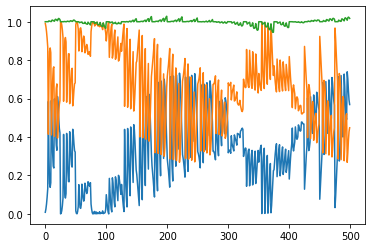

In [85]:
ref0 = np.array(ref0)
trans0 = np.array(trans0)
plt.plot(ref0)
plt.plot(trans0)
plt.plot(ref0+trans0)

## study transmission and reflection


kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0

kx,ky 0.0 0.0


matrix([[  0.-0.j,   0.+0.j,   0.+0.j,   1.+0.j],
        [  0.+0.j,   0.-0.j,  -1.+0.j,   0.+0.j],
        [  5.+0.j,  12.+0.j,   0.-0.j,   0.+0.j],
        [-12.+0.j,  -5.+0.j,   0.+0.j,   0.-0.j]])

16.999999999999996


0                   1                   2  \
0 -0.000000-0.167000j  0.000000-0.250000j  0.000000+0.167000j   
1 -0.000000-0.167000j  0.000000+0.250000j -0.000000+0.167000j   
2 -0.687000-0.000000j  0.661000-0.000000j -0.687000-0.000000j   
3  0.687000+0.000000j  0.661000+0.000000j  0.687000+0.000000j   

                    3  
0  0.000000+0.250000j  
1 -0.000000-0.250000j  
2  0.661000+0.000000j  
3  0.661000+0.000000j

[ 0.00000000e+00+4.12310563j -8.88178420e-16+2.64575131j
  9.06096933e-16-4.12310563j -2.73568330e-16-2.64575131j]
w [[-0.-0.167j  0.-0.25j ]
 [-0.-0.167j  0.+0.25j ]] 
v [[-0.687-0.j  0.661-0.j]
 [ 0.687+0.j  0.661+0.j]] 
Om [[ 0.+4.123j  0.+0.j   ]
 [ 0.+0.j    -0.+2.646j]]
A [[ 1.31016807e-16+3.72760688j -7.68290052e-16+3.72760688j]
 [ 2.69429092e-16+2.75592895j  9.88640623e-17-2.75592895j]] 
B [[ 4.94789949e-18+2.27239312j -8.01388694e-16+2.27239312j]
 [ 4.00405227e-16+1.24407105j  1.33251068e-16-1.24407105j]]
R+T 1.0


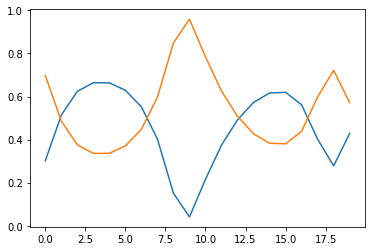

In [78]:
ref0 = []
trans0 = []
theta = 0;
phi = 0;
for wvlen in wvlen_scan:


    kx = np.sin(theta)*np.cos(phi);
    ky = np.sin(theta)*np.sin(phi);
    scale=1
    kxx=kx*scale
    kyy=ky*scale
    print('\nkx,ky',kxx,kyy)
    A = Amat(kxx,kyy,epsilon_tensor,mu_tensor)

    display(np.around(A,5))


    print(np.linalg.cond(A))
    eigenvals, eigenmodes = np.linalg.eig(A);


    ## we need to siphon off the forward propagating modes.
    sorted_eigs, sorted_inds = nonHermitianEigenSorter(np.round(eigenvals,10));

    Pg, Qg, kzg = pq.P_Q_kz(kx, ky, e_h, m_h)
    Wg = I;  # Wg should be the eigenmodes of the E field, which paparently is the identity, yes for a homogeneous medium
    sqrt_lambda = cmath.sqrt(-1) * Wg;
    Vg = Qg * Wg * (sqrt_lambda) ** -1;

    ## ========================================================
    W_i = eigenmodes[0:2, sorted_inds];
    V_i = eigenmodes[2:, sorted_inds];
    Om =  np.matrix(np.diag(sorted_eigs) );
    show(eigenmodes)
    print(eigenvals)
    print('w',np.round(W_i,3),'\nv', np.round(V_i,3),'\nOm', np.round(Om,3))

    #then what... match boundary conditions... try using the gaylord formulation.
    # or use the scattering matrix formalism, where we still, technically deal with all field components...

    Sg11 = np.matrix(np.zeros((2, 2))); Sg12 = np.matrix(np.eye(2, 2));
    Sg21 = np.matrix(np.eye(2, 2)); Sg22 = np.matrix(np.zeros((2, 2)));  # matrices
    Sg = np.block([[Sg11, Sg12], [Sg21, Sg22]]);  # initialization is equivelant as that for S_reflection side matrix

    ### ================= Working on the Reflection Side =========== ##
    Pr, Qr, kzr = pq.P_Q_kz(kx, ky, e_r, m_r)

    ## ============== values to keep track of =======================##
    S_matrices = list();
    kz_storage = [kzr];
    X_storage = list();
    ## ==============================================================##

    # define vacuum wavevector k0
    lam0 = wvlen;  # k0 and lam0 are related by 2*pi/lam0 = k0
    k0 = 2*np.pi/lam0;
    ## modes of the layer
    Om_r = np.matrix(cmath.sqrt(-1) * kzr * I);
    X_storage.append(Om_r);
    W_ref = I;
    V_ref = Qr * Om_r.I;  # can't play games with V like with W because matrices for V are complex
    #print(Om_r)
    ## calculating A and B matrices for scattering matrix
    Ar, Br = sm.A_B_matrices(W_ref, Wg, V_ref, Vg);

    S_ref, Sr_dict = sm.S_R(Ar, Br);  # scatter matrix for the reflection region
    S_matrices.append(S_ref);
    Sg, D_r, F_r = rs.RedhefferStar(Sg, S_ref);

    # longitudinal k_vector
    ## ============ WORKING INSIDE ANISOTROPIC LAYER ================#
    # now defIne A and B
#         A, B = sm.A_B_matrices(Wg, W_i, Vg, V_i);
#         W_i /= np.sqrt(np.linalg.det(W_i))
#         V_i /= np.sqrt(np.linalg.det(V_i))
    A, B = sm.A_B_matrices(W_i, Wg, V_i, Vg);
    print('A',A,'\nB',B)
#         pdb.set_trace()

    # calculate scattering matrix
    S_layer, Sl_dict = sm.S_layer(A, B, thickness, k0*scale, Om)
    S_matrices.append(S_layer);

    ## update global scattering matrix using redheffer star
    Sg, D_i, F_i = rs.RedhefferStar(Sg, S_layer);

    ##========= Working on the Transmission Side==============##
    Pt, Qt, kz_trans = pq.P_Q_kz(kx, ky, e_t, m_t);
    kz_storage.append(kz_trans);

    Omt = cmath.sqrt(-1) * kz_trans * I;
    Vt = Qt * np.linalg.inv(Omt);

    # get At, Bt
    At, Bt = sm.A_B_matrices(I, Wg, Vt, Vg)

    ST, ST_dict = sm.S_T(At, Bt)
    S_matrices.append(ST);
    # update global scattering matrix
    Sg, D_t, F_t = rs.RedhefferStar(Sg, ST);

    K_inc_vector = n_i * k0 * np.matrix([np.sin(theta) * np.cos(phi), \
                                         np.sin(theta) * np.sin(phi), np.cos(theta)]);

    # cinc is the c1+
    E_inc, cinc, Polarization = ic.initial_conditions(K_inc_vector, theta, normal_vector, pte, ptm)

    ## COMPUTE FIELDS
    Er = Sg[0:2, 0:2] * cinc;  # S11; #(cinc = initial mode amplitudes), cout = Sg*cinc; #2d because Ex, Ey...
    Et = Sg[2:, 0:2] * cinc;  # S21

    Er = np.squeeze(np.asarray(Er));
    Et = np.squeeze(np.asarray(Et));

    Erx = Er[0];  Ery = Er[1]; Etx = Et[0]; Ety = Et[1];

    # apply the grad(E) = 0 equation to get z components, this equation comes out of the longitudinal equation 
    # or the divergence equation and is valid since the transmission region is VACUUM (as is the reflection region)
    Erz = -(kx * Erx + ky * Ery) / kzr;
    Etz = -(kx * Etx + ky * Ety) / kz_trans;  ## using divergence of E equation here

#     Erz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Erx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ery) / kzr/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);
#     Etz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Etx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ety) / kz_trans/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);  ## using divergence of E equation here
#     Erz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kzr) * Erx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kzr)* Ery) /(epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kzr);
#     Etz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kz_trans) * Etx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kz_trans)* Ety) / (epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kz_trans);  ## using divergence of E equation here

#         print(kx,ky,kzr,kz_trans)

    # add in the Erz component to vectors
    Er = np.matrix([Erx, Ery, Erz]);  # a vector
    Et = np.matrix([Etx, Ety, Etz]);
#         print(E_inc)

    R = np.linalg.norm(Er) ** 2;
    T = np.linalg.norm(Et) ** 2;
#         ref.append(R);
#         trans.append(T);
#         ref.append(np.abs(Erz));
#         trans.append(np.abs(Etz));
    print('R+T',np.around(np.sum(R)+np.sum(T),2))

    ref0.append(np.sum(R))
    trans0.append(np.sum(T))
    
plt.figure();
plt.plot(ref0)
plt.plot(trans0)

0                   1                   2  \
0 -0.690000+0.328000j -0.000000+0.000000j -0.000000+0.000000j   
1 -0.217000-0.370000j -0.000000-0.000000j -0.000000-0.000000j   
2 -0.843000-0.055000j -0.000000-0.000000j -0.000000+0.000000j   
3 -0.479000+0.419000j -0.000000+0.000000j -0.000000+0.000000j   
4 -0.526000-0.410000j -0.000000-0.000000j -0.000000-0.000000j   

                    3                   4  
0 -0.000000+0.000000j -0.000000-0.000000j  
1 -0.000000-0.000000j -0.000000-0.000000j  
2 -0.000000+0.000000j -0.000000+0.000000j  
3 -0.000000-0.000000j -0.000000-0.000000j  
4 -0.000000-0.000000j -0.000000-0.000000j

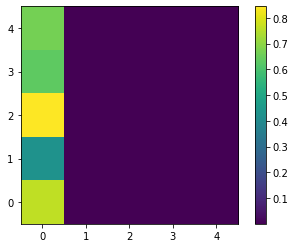

0                   1                   2  \
0  0.000000+0.000000j -0.689000+0.301000j -0.499000+0.408000j   
1  0.000000+0.000000j -0.197000-0.350000j -0.506000-0.406000j   
2  0.000000+0.000000j -0.816000-0.063000j -0.827000+0.064000j   
3  0.000000+0.000000j -0.511000+0.398000j -0.194000+0.352000j   
4  0.000000+0.000000j -0.495000-0.401000j -0.695000-0.309000j   

                    3                   4  
0 -0.187000+0.349000j -0.001000-0.025000j  
1 -0.701000-0.312000j -0.802000-0.185000j  
2 -0.790000+0.198000j -0.686000+0.330000j  
3 -0.001000-0.027000j -0.225000-0.374000j  
4 -0.798000-0.183000j -0.841000-0.052000j

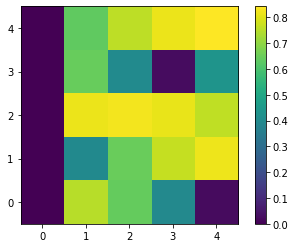

0                   1                   2  \
0 -0.000000+0.000000j  0.217000-0.095000j  0.115000-0.094000j   
1 -0.000000+0.000000j  0.062000+0.110000j  0.117000+0.094000j   
2 -0.000000+0.000000j  0.256000+0.020000j  0.191000-0.015000j   
3 -0.000000+0.000000j  0.161000-0.125000j  0.045000-0.081000j   
4 -0.000000+0.000000j  0.156000+0.126000j  0.160000+0.071000j   

                    3                   4  
0  0.028000-0.053000j  0.000000+0.002000j  
1  0.106000+0.047000j  0.060000+0.014000j  
2  0.120000-0.030000j  0.052000-0.025000j  
3  0.000000+0.004000j  0.017000+0.028000j  
4  0.121000+0.028000j  0.063000+0.004000j

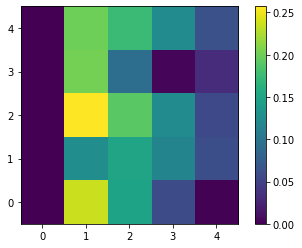

In [68]:


show((np.array(ref)).reshape(num_pts,num_pts,-1)[:,:,0])
plt.imshow(np.abs((np.array(ref)).reshape(num_pts,num_pts,-1)[:,:,0]),origin='lower')
plt.colorbar()
plt.show()
show((np.array(ref)).reshape(num_pts,num_pts,-1)[:,:,1])
plt.imshow(np.abs((np.array(ref)).reshape(num_pts,num_pts,-1)[:,:,1]),origin='lower')
plt.colorbar()
plt.show()
show((np.array(ref)).reshape(num_pts,num_pts,-1)[:,:,2])
plt.imshow(np.abs((np.array(ref)).reshape(num_pts,num_pts,-1)[:,:,2]),origin='lower')
plt.colorbar()
plt.show()

0                   1                   2  \
0 -0.413000+0.911000j -0.000000+0.000000j -0.000000+0.000000j   
1  0.561000-0.828000j  0.000000-0.000000j -0.000000-0.000000j   
2 -0.808000-0.589000j -0.000000-0.000000j -0.000000-0.000000j   
3 -0.987000-0.161000j -0.000000-0.000000j -0.000000-0.000000j   
4 -0.984000+0.177000j -0.000000+0.000000j -0.000000+0.000000j   

                    3                   4  
0  0.000000+0.000000j  0.000000-0.000000j  
1 -0.000000-0.000000j -0.000000-0.000000j  
2 -0.000000-0.000000j -0.000000-0.000000j  
3 -0.000000+0.000000j -0.000000+0.000000j  
4 -0.000000+0.000000j -0.000000+0.000000j

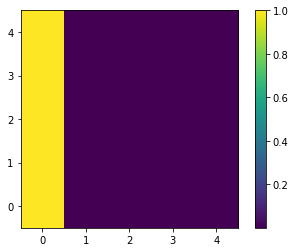

0                   1                   2  \
0  0.000000+0.000000j -0.453000+0.839000j -0.037000+0.974000j   
1  0.000000+0.000000j  0.558000-0.774000j -0.052000-0.973000j   
2  0.000000+0.000000j -0.778000-0.553000j -0.867000-0.445000j   
3  0.000000+0.000000j -0.941000-0.155000j -0.971000-0.077000j   
4  0.000000+0.000000j -0.942000+0.150000j -0.942000+0.248000j   

                    3                   4  
0  0.613000+0.776000j  0.996000-0.055000j  
1 -0.448000-0.882000j -0.675000-0.734000j  
2 -0.926000-0.345000j -0.965000-0.251000j  
3 -0.989000+0.005000j -0.993000+0.090000j  
4 -0.922000+0.358000j -0.874000+0.480000j

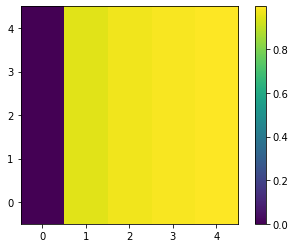

0                   1                   2  \
0 -0.000000+0.000000j  0.143000-0.264000j  0.009000-0.225000j   
1 -0.000000+0.000000j -0.175000+0.243000j  0.012000+0.225000j   
2 -0.000000+0.000000j  0.245000+0.174000j  0.200000+0.103000j   
3 -0.000000+0.000000j  0.296000+0.049000j  0.224000+0.018000j   
4 -0.000000+0.000000j  0.296000-0.047000j  0.218000-0.057000j   

                    3                   4  
0 -0.093000-0.118000j -0.075000+0.004000j  
1  0.068000+0.134000j  0.051000+0.055000j  
2  0.141000+0.052000j  0.073000+0.019000j  
3  0.150000-0.001000j  0.075000-0.007000j  
4  0.140000-0.054000j  0.066000-0.036000j

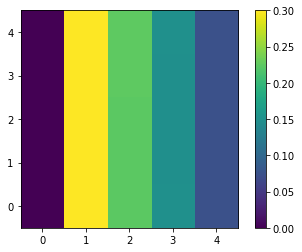

In [69]:
show((np.array(ref)+np.array(trans)).reshape(num_pts,num_pts,-1)[:,:,0])
plt.imshow(np.abs((np.array(ref)+np.array(trans)).reshape(num_pts,num_pts,-1)[:,:,0]),origin='lower')
plt.colorbar()
plt.show()
show((np.array(ref)+np.array(trans)).reshape(num_pts,num_pts,-1)[:,:,1])
plt.imshow(np.abs((np.array(ref)+np.array(trans)).reshape(num_pts,num_pts,-1)[:,:,1]),origin='lower')
plt.colorbar()
plt.show()
show((np.array(ref)+np.array(trans)).reshape(num_pts,num_pts,-1)[:,:,2])
plt.imshow(np.abs((np.array(ref)+np.array(trans)).reshape(num_pts,num_pts,-1)[:,:,2]),origin='lower')
plt.colorbar()
plt.show()

# probing topology

[1.63934426]


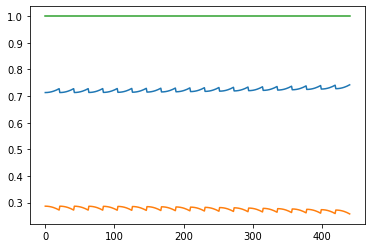

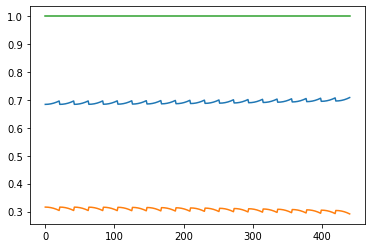

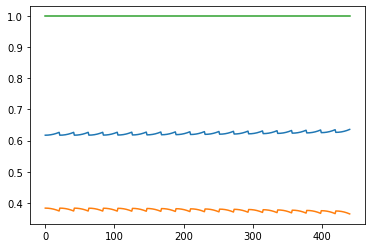

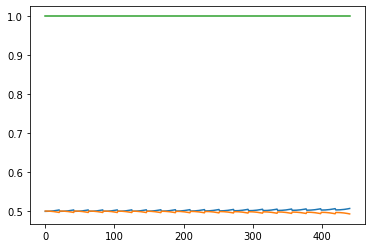

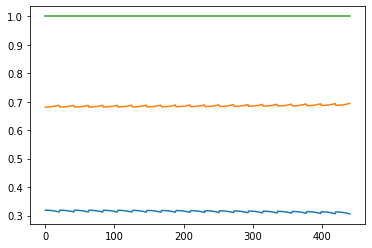

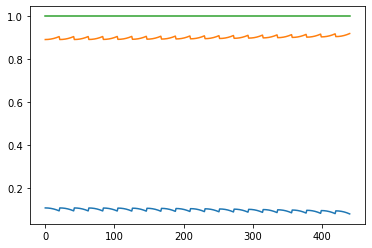

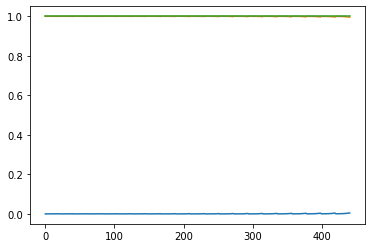

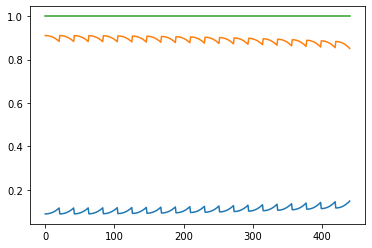

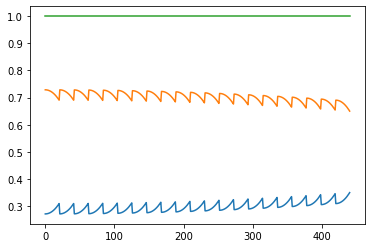

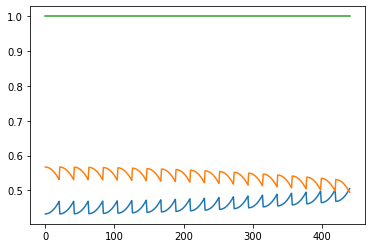

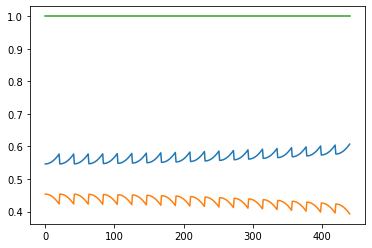

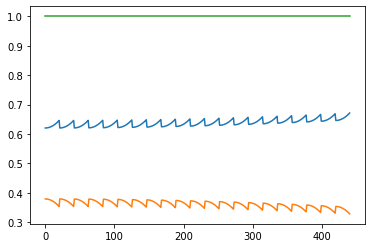

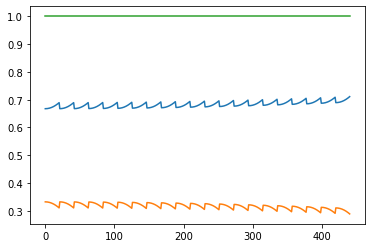

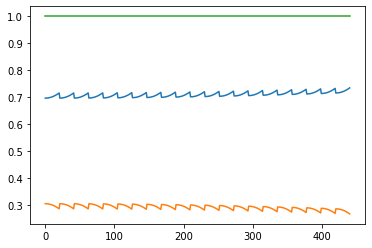

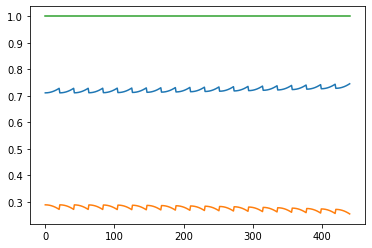

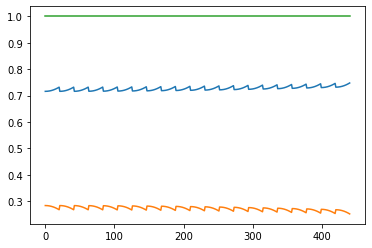

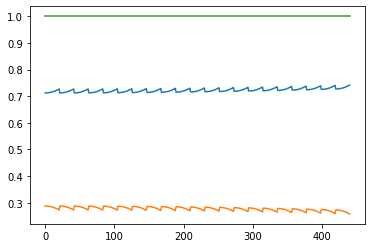

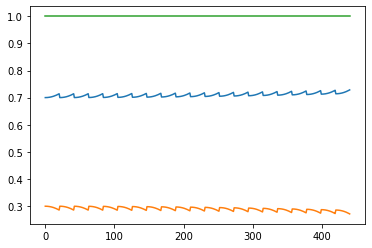

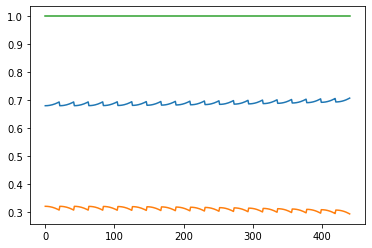

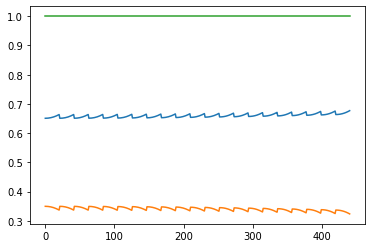

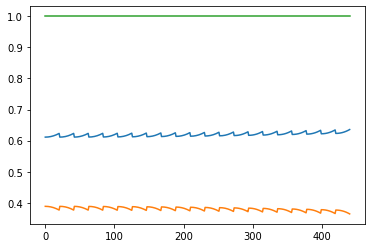

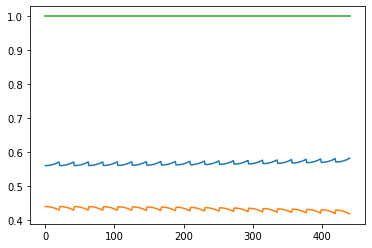

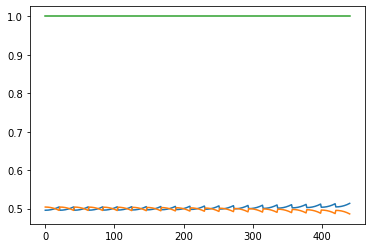

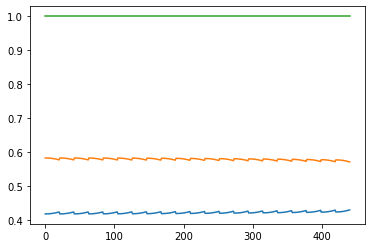

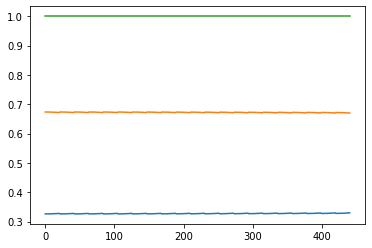

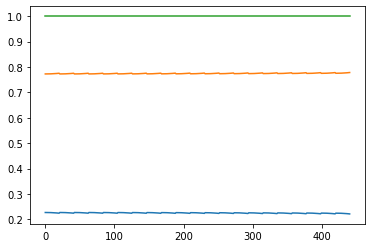

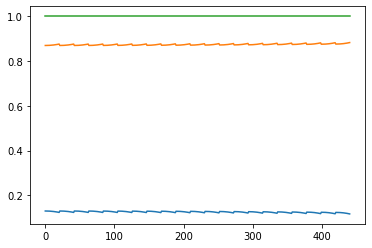

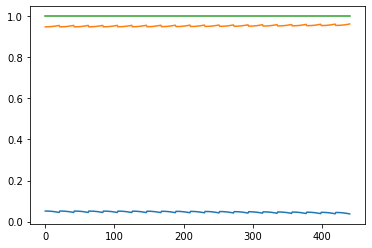

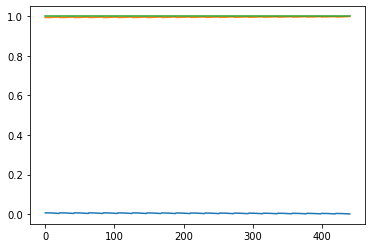

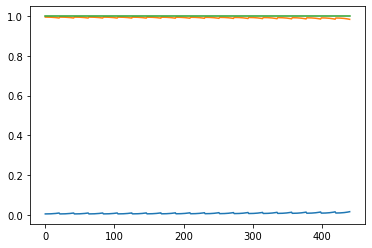

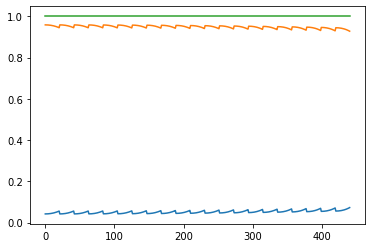

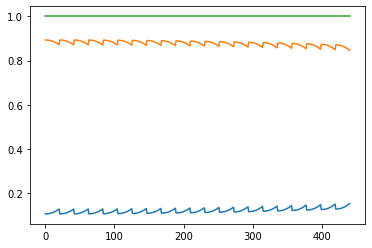

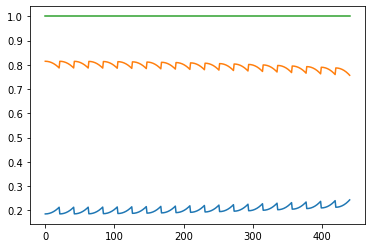

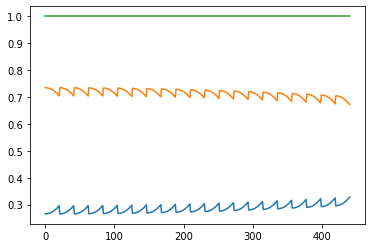

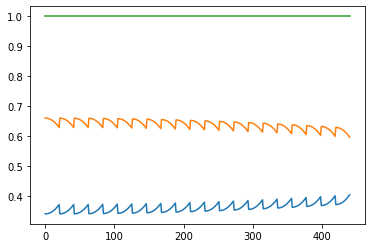

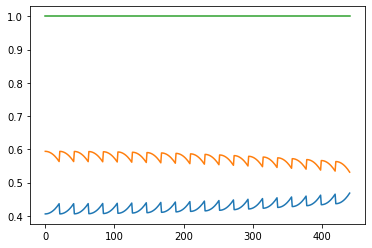

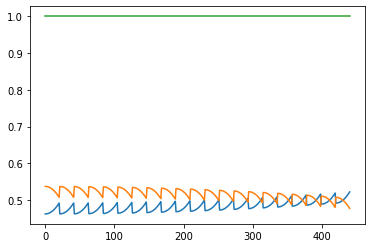

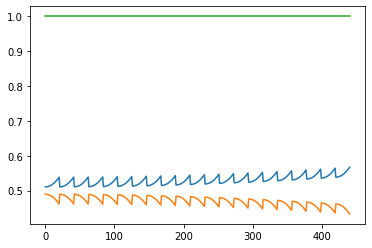

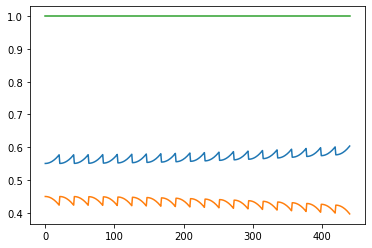

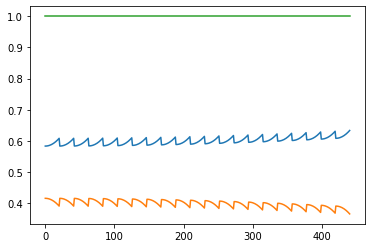

In [70]:
ref = [];
trans = [];
freqs = np.linspace(0.61,1,1)
wvlen_scan = 1/freqs;
thickness = 0.5; # 1 layer

num_pts = 21
kxs = np.linspace(0,0.15,num_pts)
kys = np.linspace(0,0.15,num_pts)
kxs,kys = np.meshgrid(kxs,kys)
kxs = kxs.flatten()
kys = kys.flatten()
phis = np.arctan((kys+1e-9)/(kxs+1e-9))
thetas = np.arcsin(np.sqrt(kxs**2 + kys**2) / freqs[0])
eps_tensors=[np.diag([2,8,8]),-1e3*np.eye(3)]
mu_tensors=[]

epsilon_tensor = np.array([[12,0,0],[0,12,0],[0,0,12]]);
print(wvlen_scan)
wvlen_scan = np.linspace(1,2,40)
for wvlen in wvlen_scan:
    k0 = 2*np.pi/wvlen;
    Rspec = [];
    Tspec = [];
    for ki in range(len(thetas)):
        theta = thetas[ki] 
#         theta = 0
        phi = phis[ki]
#         phi=0
        kx = np.sin(theta)*np.cos(phi);
        ky = np.sin(theta)*np.sin(phi);
        scale=1
        kxx=kx*scale
        kyy=ky*scale
#         print('kx,ky',kxx,kyy)
        A = Amat(kxx,kyy,epsilon_tensor,mu_tensor)
        eigenvals, eigenmodes = np.linalg.eig(A);

        ## we need to siphon off the forward propagating modes.
        sorted_eigs, sorted_inds = nonHermitianEigenSorter(np.round(eigenvals,10));

        Pg, Qg, kzg = pq.P_Q_kz(kx, ky, e_h, m_h)
        Wg = I;  # Wg should be the eigenmodes of the E field, which paparently is the identity, yes for a homogeneous medium
        sqrt_lambda = cmath.sqrt(-1) * Wg;
        Vg = Qg * Wg * (sqrt_lambda) ** -1;


        ## ========================================================
        W_i = eigenmodes[0:2, sorted_inds];
        V_i = eigenmodes[2:, sorted_inds];
        Om =  np.matrix(np.diag(sorted_eigs) );
#         show(eigenmodes)
#         print(eigenvals)
#         print('w',np.round(W_i,3),'\nv', np.round(V_i,3),'\nOm', np.round(Om,3))

        #then what... match boundary conditions... try using the gaylord formulation.
        # or use the scattering matrix formalism, where we still, technically deal with all field components...

        Sg11 = np.matrix(np.zeros((2, 2))); Sg12 = np.matrix(np.eye(2, 2));
        Sg21 = np.matrix(np.eye(2, 2)); Sg22 = np.matrix(np.zeros((2, 2)));  # matrices
        Sg = np.block([[Sg11, Sg12], [Sg21, Sg22]]);  # initialization is equivelant as that for S_reflection side matrix

        ### ================= Working on the Reflection Side =========== ##
        Pr, Qr, kzr = pq.P_Q_kz(kx, ky, e_r, m_r)

        ## ============== values to keep track of =======================##
        S_matrices = list();
        kz_storage = [kzr];
        X_storage = list();
        ## ==============================================================##

        # define vacuum wavevector k0
        lam0 = wvlen;  # k0 and lam0 are related by 2*pi/lam0 = k0
        k0 = 2*np.pi/lam0;
        ## modes of the layer
        Om_r = np.matrix(cmath.sqrt(-1) * kzr * I);
        X_storage.append(Om_r);
        W_ref = I;
        V_ref = Qr * Om_r.I;  # can't play games with V like with W because matrices for V are complex
        #print(Om_r)
        ## calculating A and B matrices for scattering matrix
        Ar, Br = sm.A_B_matrices(W_ref, Wg, V_ref, Vg);

        S_ref, Sr_dict = sm.S_R(Ar, Br);  # scatter matrix for the reflection region
        S_matrices.append(S_ref);
        Sg, D_r, F_r = rs.RedhefferStar(Sg, S_ref);

        # longitudinal k_vector
        ## ============ WORKING INSIDE ANISOTROPIC LAYER ================#
        # now defIne A and B
#         A, B = sm.A_B_matrices(Wg, W_i, Vg, V_i);
        A, B = sm.A_B_matrices(W_i, Wg, V_i, Vg);

        # calculate scattering matrix
        S_layer, Sl_dict = sm.S_layer(A, B, thickness, k0*scale, Om)
        S_matrices.append(S_layer);

        ## update global scattering matrix using redheffer star
        Sg, D_i, F_i = rs.RedhefferStar(Sg, S_layer);

        ##========= Working on the Transmission Side==============##
        Pt, Qt, kz_trans = pq.P_Q_kz(kx, ky, e_t, m_t);
        kz_storage.append(kz_trans);

        Omt = cmath.sqrt(-1) * kz_trans * I;
        Vt = Qt * np.linalg.inv(Omt);

        # get At, Bt
        At, Bt = sm.A_B_matrices(I, Wg, Vt, Vg)

        ST, ST_dict = sm.S_T(At, Bt)
        S_matrices.append(ST);
        # update global scattering matrix
        Sg, D_t, F_t = rs.RedhefferStar(Sg, ST);

        K_inc_vector = n_i * k0 * np.matrix([np.sin(theta) * np.cos(phi), \
                                             np.sin(theta) * np.sin(phi), np.cos(theta)]);

        # cinc is the c1+
        E_inc, cinc, Polarization = ic.initial_conditions(K_inc_vector, theta, normal_vector, pte, ptm)

        ## COMPUTE FIELDS
        Er = Sg[0:2, 0:2] * cinc;  # S11; #(cinc = initial mode amplitudes), cout = Sg*cinc; #2d because Ex, Ey...
        Et = Sg[2:, 0:2] * cinc;  # S21

        Er = np.squeeze(np.asarray(Er));
        Et = np.squeeze(np.asarray(Et));

        Erx = Er[0];  Ery = Er[1]; Etx = Et[0]; Ety = Et[1];

        # or the divergence equation and is valid since the transmission region is VACUUM (as is the reflection region)
        Erz = -(kx * Erx + ky * Ery) / kzr;
        Etz = -(kx * Etx + ky * Ety) / kz_trans;  ## using divergence of E equation here

    #     Erz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Erx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ery) / kzr/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);
    #     Etz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Etx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ety) / kz_trans/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);  ## using divergence of E equation here
    #     Erz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kzr) * Erx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kzr)* Ery) /(epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kzr);
    #     Etz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kz_trans) * Etx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kz_trans)* Ety) / (epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kz_trans);  ## using divergence of E equation here

        # add in the Erz component to vectors
        Er = np.matrix([Erx, Ery, Erz]);  # a vector
        Et = np.matrix([Etx, Ety, Etz]);

        R = np.linalg.norm(Er) ** 2;
        T = np.linalg.norm(Et) ** 2;
        Rspec.append(R);
        Tspec.append(T);
#         ref.append(R);
#         trans.append(T);
        if np.around(R+T,3)!=1:
            print('R+T',np.around(np.sum(R)+np.sum(T),2))
        ref.append([Erx,Ery,Erz]);
        trans.append([Etx,Ety,Etz]);
    
    plt.plot(Rspec)
    plt.plot(Tspec)
    plt.plot(np.array(Rspec)+np.array(Tspec))
    plt.show()

In [43]:
trans = np.array(trans)
ref = np.array(ref)
print(trans.shape)


(500, 3)


In [44]:
trans[ki,:2]

array([0.48506428-0.32201865j, 0.48506428-0.32201864j])

In [45]:
num_pts

5

In [46]:
trans.shape

(500, 3)

In [47]:
trans_rot = trans.reshape(num_pts*num_pts,3)
ref_rot = ref.reshape(num_pts*num_pts,3)
for ki in range(num_pts*num_pts):
    phi = phis[ki]
    rot = np.array([[cos(phi),sin(phi)],[-sin(phi),cos(phi)]])
    trans_rot[ki,:2] = rot@trans_rot[ki,:2]
    ref_rot[ki,:2] = rot@ref_rot[ki,:2]

ValueError: cannot reshape array of size 1500 into shape (25,3)

In [ ]:
ref_rot = ref_rot.reshape(num_pts,num_pts,3);
trans_rot = trans_rot.reshape(num_pts,num_pts,3)
plt.figure(figsize=[10,2])
plt.subplot(141)
plt.imshow(np.abs(ref_rot[:,:,0]),origin='lower',extent=[0,0.15,0,0.15])
plt.colorbar()
plt.subplot(142)
plt.imshow(np.abs(ref_rot[:,:,1]),origin='lower',extent=[0,0.15,0,0.15])
plt.colorbar()
plt.subplot(143)
plt.imshow(np.abs(ref_rot[:,:,2]),origin='lower',extent=[0,0.15,0,0.15])
plt.colorbar()
plt.subplot(144)
plt.imshow(np.linalg.norm(ref_rot[:,:,:],axis=2)**2+np.linalg.norm(trans_rot[:,:,:],axis=2)**2,origin='lower',extent=[0,0.15,0,0.15])
plt.colorbar()
plt.tight_layout(); plt.show()

In [48]:
ref = ref.reshape(num_pts,num_pts,3);
trans = trans.reshape(num_pts,num_pts,3)
plt.figure(figsize=[10,2])
plt.subplot(131)
plt.imshow(np.abs(ref[:,:,0]),origin='lower',extent=[0,0.15,0,0.15])
plt.colorbar()
plt.subplot(132)
plt.imshow(np.abs(ref[:,:,1]),origin='lower',extent=[0,0.15,0,0.15])
plt.colorbar()
plt.subplot(133)
plt.imshow(np.abs(ref[:,:,2]),origin='lower',extent=[0,0.15,0,0.15])
plt.colorbar()
plt.tight_layout(); plt.show()

ValueError: cannot reshape array of size 1500 into shape (5,5,3)

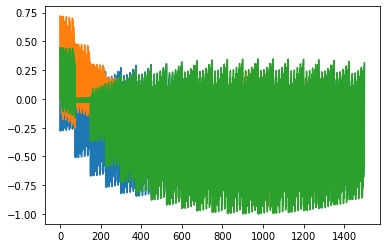

In [49]:
plt.plot(ref.flatten(),label='ref')
plt.plot(trans.flatten(),label='trans')
plt.plot(trans.flatten()+ref.flatten(),label='ref+trans')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (500, 3)

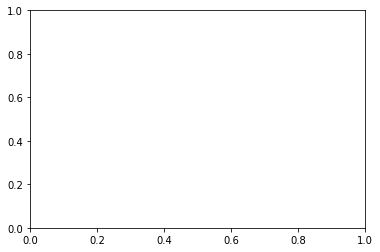

In [50]:
ref = np.array(ref);
trans = np.array(trans)
plt.plot(wvlen_scan, ref);
plt.plot(wvlen_scan, trans);
plt.plot(wvlen_scan, ref+trans)
plt.show()
print(Et)



ValueError: x and y must have same first dimension, but have shapes (20,) and (500, 3)

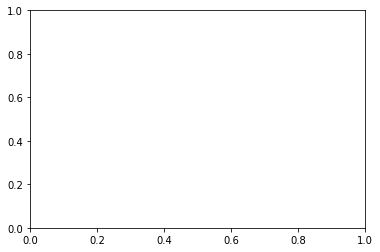

In [51]:
ref = np.array(ref);
trans = np.array(trans)
plt.plot(wvlen_scan, ref);
plt.plot(wvlen_scan, trans);
plt.plot(wvlen_scan, ref+trans)
plt.show()
print(Et)


ValueError: x and y must have same first dimension, but have shapes (20,) and (500, 3)

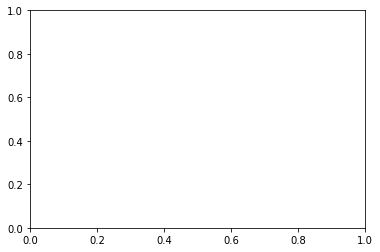

In [52]:
ref = np.array(ref);
trans = np.array(trans)
plt.plot(wvlen_scan, ref);
plt.plot(wvlen_scan, trans);
plt.plot(wvlen_scan, ref+trans)
plt.show()
print(Et)

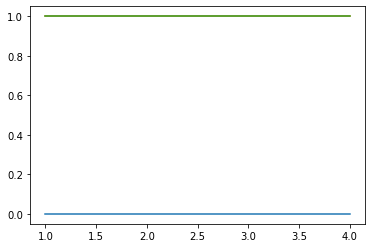

[[ 0.56853287+0.j  0.69534348+0.j -0.43962236+0.j]]


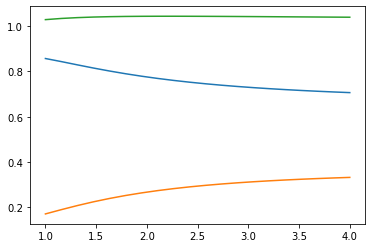

[[ 0.48712677-0.26346957j -0.05006104+0.0251995j  -0.13195118+0.07207885j]]


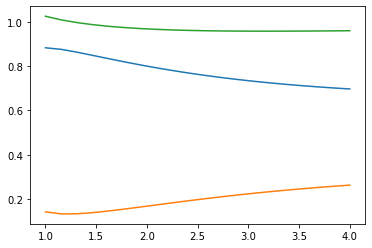

[[ 0.42962469-0.24055699j -0.04412091+0.02375184j -0.11638687+0.06552868j]]


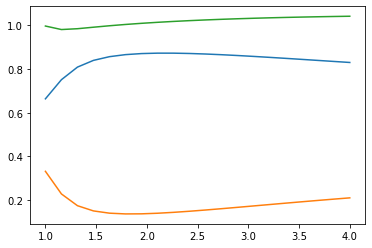

[[ 0.2076426 -0.38934991j -0.02133437+0.03931828j -0.05624726+0.10572886j]]


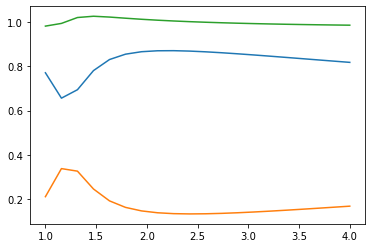

[[ 0.18468018-0.3476546j  -0.01896198+0.03515947j -0.05003204+0.09438679j]]


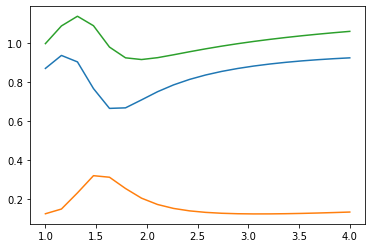

[[-0.06841921-0.34657027j  0.00700886+0.03510663j  0.01854166+0.09407087j]]


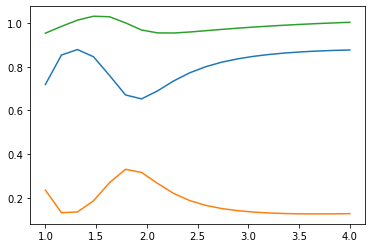

[[-0.02318486-0.34151204j  0.00237429+0.03460255j  0.0062834 +0.09269474j]]


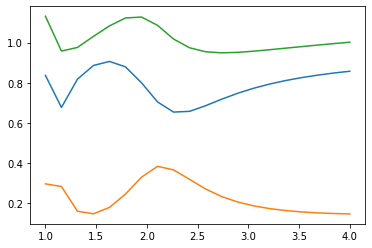

[[-0.1345532 -0.33990079j  0.01379143+0.03442223j  0.03646106+0.09226388j]]


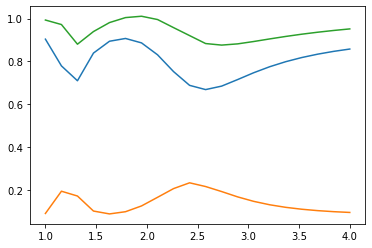

[[-0.13684587-0.26095241j  0.01402305+0.02629443j  0.03708361+0.07088409j]]


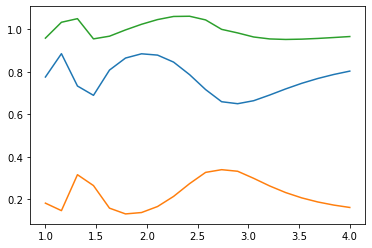

[[-0.21379126-0.32273833j  0.02190099+0.03254814j  0.05793751+0.08765678j]]


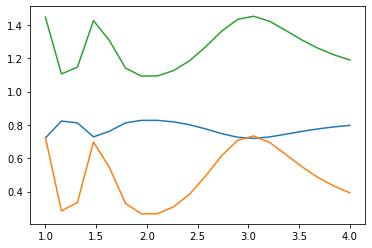

[[-0.31899601-0.51037859j  0.03266864+0.05160333j  0.08645169+0.1385706j ]]


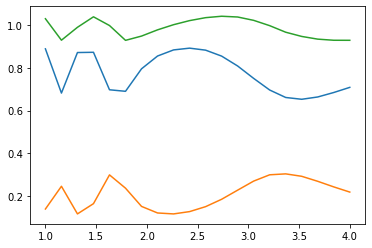

[[-0.38746383-0.22907009j  0.03964049+0.02257909j  0.10502243+0.06241421j]]


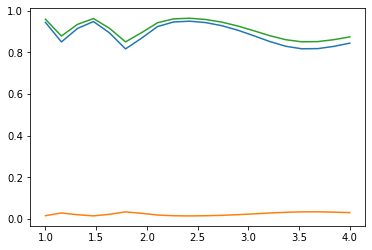

[[-0.14649666-0.07920006j  0.01496764+0.00670304j  0.03971567+0.02199764j]]


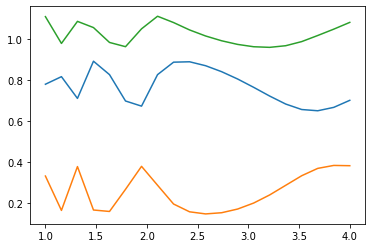

[[-0.54570935-0.23188406j  0.05587603+0.01783151j  0.14789766+0.06508499j]]


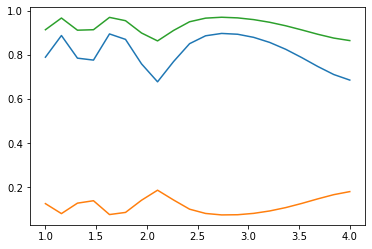

[[-0.39811309+0.08175856j  0.04062671-0.0054588j   0.10794806-0.02326178j]]


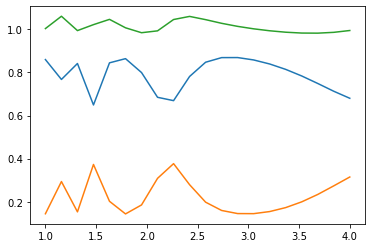

[[-0.49013524+0.22368777j  0.0499817 -0.02160131j  0.13291332-0.06111718j]]


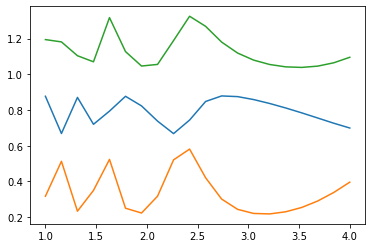

[[-0.49578664+0.3458249j   0.05048443-0.03441881j  0.13447373-0.09410057j]]


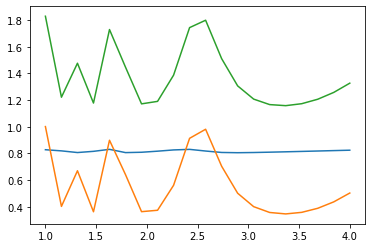

[[-0.31496343+0.60388854j  0.03202331-0.06074074j  0.08544685-0.16407925j]]


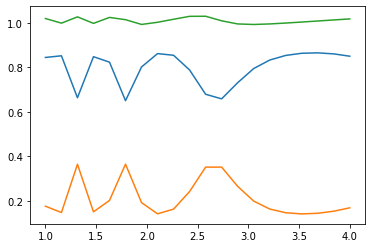

[[-0.11295387+0.37708007j  0.01148896-0.03782589j  0.03064167-0.10249295j]]


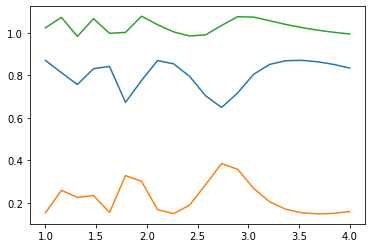

[[-0.13614336+0.35939464j  0.01381663-0.03602695j  0.03694418-0.09769535j]]


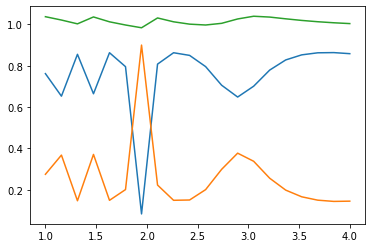

[[-0.05097723+0.36269896j  0.00516684-0.03633996j  0.01383581-0.09860048j]]


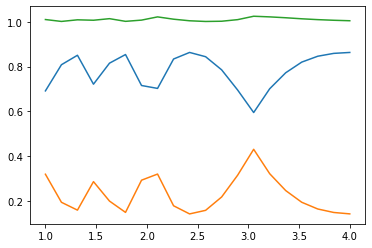

[[ 0.0089577 +0.36147898j -0.00090854-0.0361678j  -0.00243099-0.09828775j]]


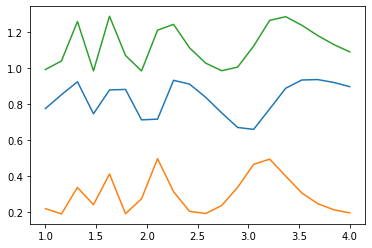

[[-0.09539079+0.41201453j  0.00960616-0.04114363j  0.02591375-0.11205909j]]


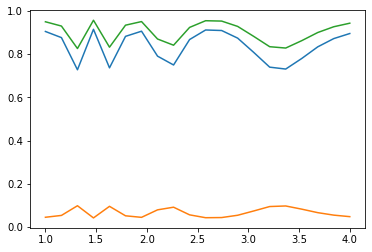

[[ 0.06752977+0.19891404j -0.00680516-0.01958183j -0.01834328-0.05420707j]]


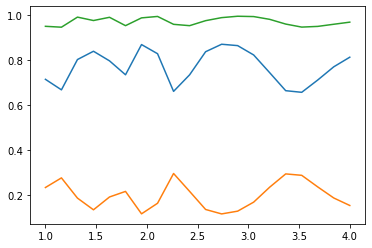

[[ 0.19151912+0.32687792j -0.01929612-0.032388j   -0.05202425-0.08899998j]]


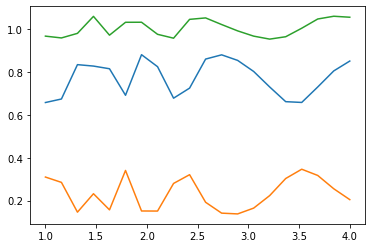

[[ 0.17646224+0.39672594j -0.01776588-0.03923282j -0.04793921-0.10804647j]]


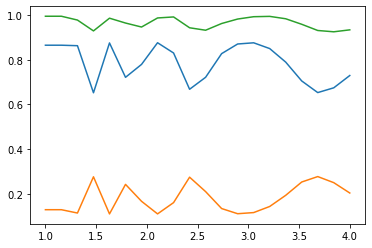

[[ 0.34873594+0.25818084j -0.03499659-0.02506087j -0.09478353-0.07049283j]]


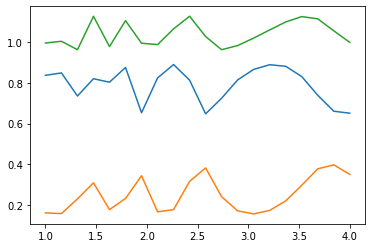

[[ 0.55399643+0.12390759j -0.05541245-0.0111139j  -0.15064081-0.03417744j]]


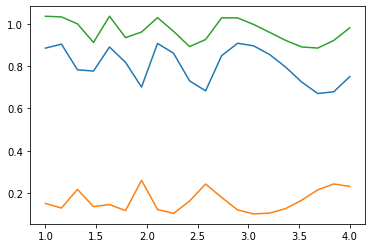

[[ 0.37278446+0.27216963j -0.03732791-0.02469432j -0.10135079-0.0749657j ]]


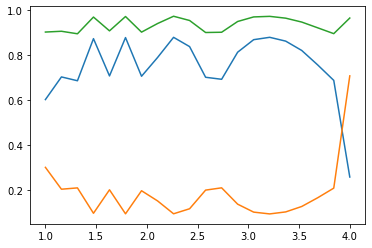

[[ 0.53155212+0.05933979j  0.40701138+0.36193229j -0.31890971-0.1555286j ]]


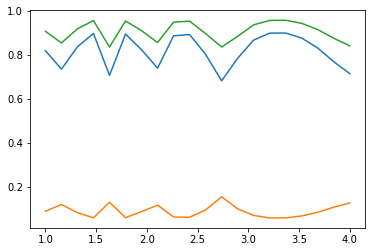

[[ 0.32979574-0.088154j   -0.03273786+0.00627176j -0.0897714 +0.02493515j]]


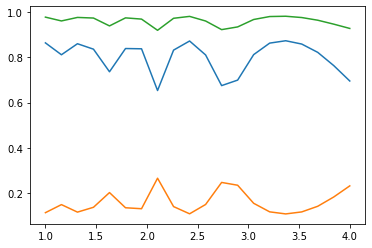

[[ 0.41539961-0.20380508j -0.0412191 +0.01889322j -0.11307925+0.05598333j]]


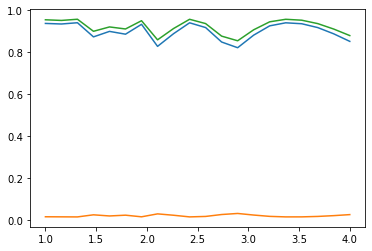

[[ 0.13777806-0.08043596j -0.01348913+0.00707042j -0.03757473+0.02224133j]]


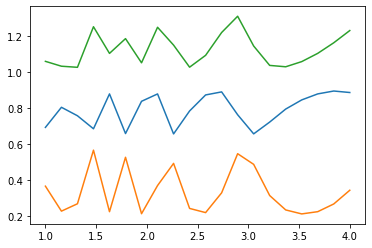

[[ 0.22372679-0.51652632j -0.0221075 +0.05015569j -0.06093746+0.14102381j]]


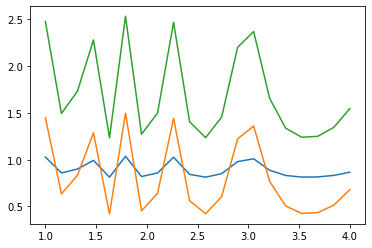

[[ 0.38898696-0.68939717j -0.03776591+0.0661622j  -0.10620464+0.18851701j]]


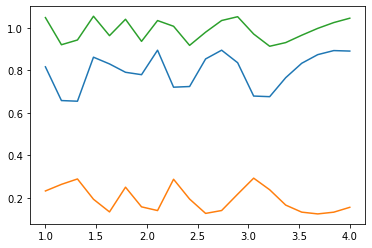

[[ 0.06476685-0.3721973j  -0.0063756 +0.03592288j -0.01765005+0.10170128j]]


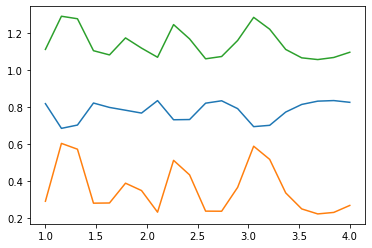

[[ 0.15499061-0.47486601j -0.01517615+0.0459459j  -0.04226823+0.1297119j ]]


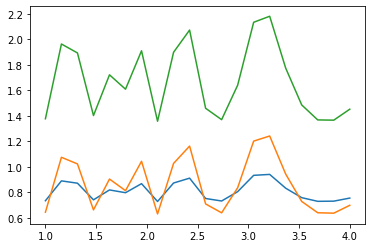

[[ 0.24283516-0.76477552j -0.02648276+0.0839602j  -0.06519969+0.20512649j]]


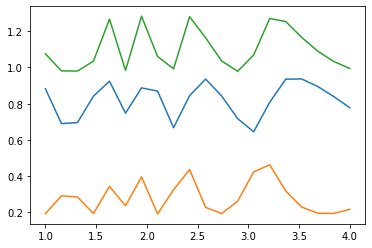

[[ 0.27885803-0.34978689j -0.02684004+0.03329684j -0.07622482+0.0957532j ]]


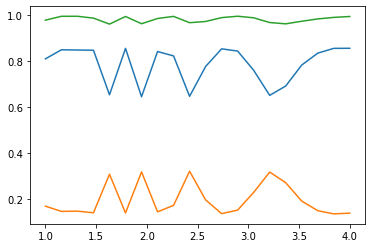

[[ 0.03933687-0.35500848j -0.00381086+0.03392726j -0.01074323+0.09713206j]]


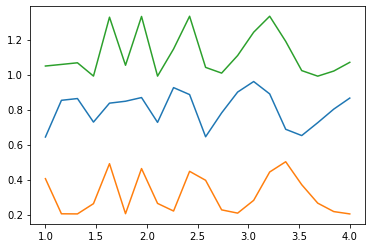

[[-0.1626195 -0.4023944j   0.01544274+0.03796618j  0.04453078+0.11028261j]]


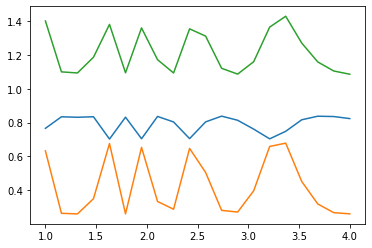

[[ 0.06464083-0.48712269j -0.00619019+0.04631224j -0.01768127+0.13337042j]]


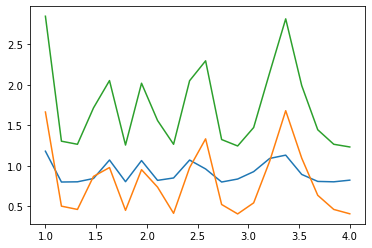

[[-0.09035458-0.60787644j  0.0083069 +0.05575831j  0.02484576+0.16720272j]]


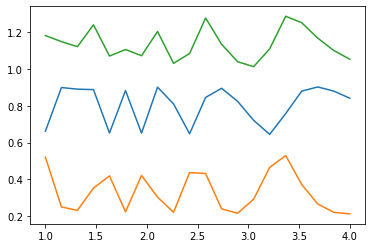

[[ 0.12846874-0.4230907j  -0.01210365+0.03962276j -0.03521553+0.11606698j]]


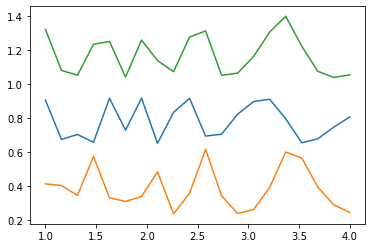

[[-0.19156518-0.43729671j  0.01794562+0.0406859j   0.05255026+0.1200654j ]]


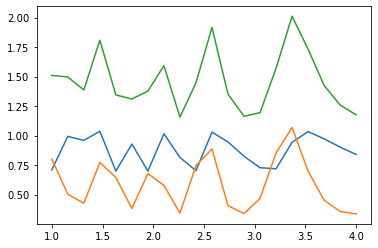

[[ 0.13303685-0.540579j   -0.01216564+0.04938746j -0.03660732+0.14876685j]]


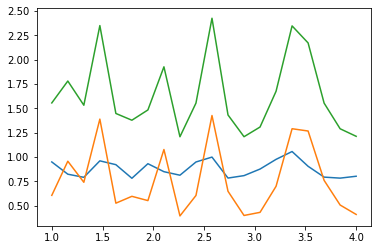

[[-0.15646772-0.59464619j  0.01436211+0.05430343j  0.04303432+0.16365504j]]


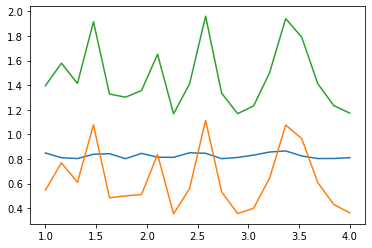

[[-0.08948372-0.5710783j   0.00830345+0.05259423j  0.02457726+0.15700095j]]


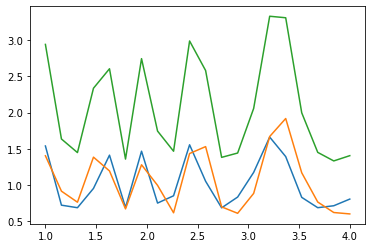

[[-0.43473016-0.60360228j  0.05562725+0.05778375j  0.11360863+0.16511103j]]


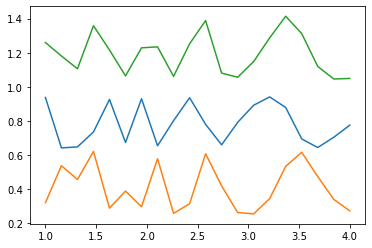

[[-0.2513551 -0.43523722j  0.02262101+0.03895256j  0.06930262+0.12008413j]]


In [54]:

for scale in np.linspace(0,5,50):
    ref = [];
    trans = []
    wvlen_scan = np.linspace(1, 4, 20);
    thickness = 0.5; # 1 layer
    for wvlen in wvlen_scan:
        k0 = 2*np.pi/wvlen;
        kx = np.sin(theta)*np.cos(phi);
        ky = np.sin(theta)*np.sin(phi);

        kxx=kx*scale
        kyy=ky*scale

        a11 = -1j*(kyy*mu_tensor[1,2]/mu_tensor[2,2] + kxx*(epsilon_tensor[2,0]/epsilon_tensor[2,2]))
        a12 = 1j*kxx*(mu_tensor[1,2]/mu_tensor[2,2] - epsilon_tensor[2,1]/epsilon_tensor[2,2]);
        a13 = kxx*kyy/epsilon_tensor[2,2] + mu_tensor[1,0] - mu_tensor[1,2]*mu_tensor[2,0]/mu_tensor[2,2];
        a14 = -kxx**2/epsilon_tensor[2,2] + mu_tensor[1,1]-  mu_tensor[1,2]*mu_tensor[2,1]/mu_tensor[2,2];

        a21 = 1j* kyy *(mu_tensor[0,2]/mu_tensor[2,2] - epsilon_tensor[2,0]/epsilon_tensor[2,2]);
        a22 = -1j * kxx*(mu_tensor[0,2]/mu_tensor[2,2]) +kyy *(epsilon_tensor[2,1]/epsilon_tensor[2,2]);
        a23 = kyy**2/epsilon_tensor[2,2] - mu_tensor[0,0] +  mu_tensor[0,2]*mu_tensor[2,0]/mu_tensor[2,2];
        a24 =  -kxx*kyy/epsilon_tensor[2,2] - mu_tensor[0,1] + mu_tensor[0,2]*mu_tensor[2,1]/mu_tensor[2,2];

        a31 = (kxx*kyy/mu_tensor[2,2] + epsilon_tensor[1,0] - epsilon_tensor[1,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2])
        a32 = (-kxx**2/mu_tensor[2,2] +epsilon_tensor[1,1] - epsilon_tensor[1,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2]);
        a33 = -1j*(kyy*(epsilon_tensor[1,2]/epsilon_tensor[2,2])+kxx*(mu_tensor[2,0]/mu_tensor[2,2]));
        a34 = 1j*kxx*(epsilon_tensor[1,2]/epsilon_tensor[2,2]-mu_tensor[2,1]/mu_tensor[2,2] )

        a41 = kyy**2/mu_tensor[2,2] - epsilon_tensor[0,0] +  epsilon_tensor[0,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2];
        a42 = -kxx*kyy/mu_tensor[2,2] - epsilon_tensor[0,1] + epsilon_tensor[0,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2];
        a43 = 1j*kyy*(epsilon_tensor[0,2]/epsilon_tensor[2,2]-mu_tensor[2,0]/mu_tensor[2,2] );
        a44 = -1j*(kxx*(epsilon_tensor[0,2]/epsilon_tensor[2,2])+kyy*(mu_tensor[2,1]/mu_tensor[2,2]));


        A = np.matrix([[a11, a12, a13, a14],
                      [a21, a22, a23, a24],
                      [a31, a32, a33, a34],
                      [a41, a42, a43, a44]]);

        #print(np.linalg.cond(A))
        eigenvals, eigenmodes = np.linalg.eig(A);
        rounded_eigenvals = np.round(eigenvals, 3)


        #print(np.round(eigenvals,3)); print(np.round(eigenmodes,3))

        ## suppose we directly diagonalize this matrix.


        ## we need to siphon off the forward propagating modes.
        sorted_eigs, sorted_inds = nonHermitianEigenSorter(np.round(eigenvals,10));
    #     sorted_inds = [1,3];
    #     sorted_eigs = eigenvals[sorted_inds];
        #print(sorted_eigs) ## since we have Ey, Ex, Hy, Hx, on a uniform slab, there is a 2-fold degeneracy 

    #     plt.plot(np.real(rounded_eigenvals), np.imag(rounded_eigenvals), 'o')
    #     plt.plot(np.real(sorted_eigs), np.imag(sorted_eigs), '.r')
    #     plt.show()

        ## ========================================================
        W_i = eigenmodes[0:2, sorted_inds];
        V_i = eigenmodes[2:, sorted_inds];
        Om =  np.matrix(np.diag(sorted_eigs) );
        #print(np.round(W_i,3), np.round(V_i,3), np.round(Om,3))

        #then what... match boundary conditions... try using the gaylord formulation.
        # or use the scattering matrix formalism, where we still, technically deal with all field components...

        Sg11 = np.matrix(np.zeros((2, 2))); Sg12 = np.matrix(np.eye(2, 2));
        Sg21 = np.matrix(np.eye(2, 2)); Sg22 = np.matrix(np.zeros((2, 2)));  # matrices
        Sg = np.block([[Sg11, Sg12], [Sg21, Sg22]]);  # initialization is equivelant as that for S_reflection side matrix

        ### ================= Working on the Reflection Side =========== ##
        Pr, Qr, kzr = pq.P_Q_kz(kx, ky, e_r, m_r)

        ## ============== values to keep track of =======================##
        S_matrices = list();
        kz_storage = [kzr];
        X_storage = list();
        ## ==============================================================##

        # define vacuum wavevector k0
        lam0 = wvlen;  # k0 and lam0 are related by 2*pi/lam0 = k0
        k0 = 2*np.pi/lam0;
        ## modes of the layer
        Om_r = np.matrix(cmath.sqrt(-1) * kzr * I);
        X_storage.append(Om_r);
        W_ref = I;
        V_ref = Qr * Om_r.I;  # can't play games with V like with W because matrices for V are complex
        #print(Om_r)
        ## calculating A and B matrices for scattering matrix
        Ar, Br = sm.A_B_matrices(Wg, W_ref, Vg, V_ref);

        S_ref, Sr_dict = sm.S_R(Ar, Br);  # scatter matrix for the reflection region
        S_matrices.append(S_ref);
        Sg, D_r, F_r = rs.RedhefferStar(Sg, S_ref);

        # longitudinal k_vector
        ## ============ WORKING INSIDE ANISOTROPIC LAYER ================#
        # now defIne A and B
        A, B = sm.A_B_matrices(Wg, W_i, Vg, V_i);

        # calculate scattering matrix
        S_layer, Sl_dict = sm.S_layer(A, B, thickness, k0*scale, Om)
        S_matrices.append(S_layer);

        ## update global scattering matrix using redheffer star
        Sg, D_i, F_i = rs.RedhefferStar(Sg, S_layer);

        ##========= Working on the Transmission Side==============##
        Pt, Qt, kz_trans = pq.P_Q_kz(kx, ky, e_t, m_t);
        kz_storage.append(kz_trans);

        Omt = cmath.sqrt(-1) * kz_trans * I;
        Vt = Qt * np.linalg.inv(Omt);

        # get At, Bt
        At, Bt = sm.A_B_matrices(Wg, I, Vg, Vt)

        ST, ST_dict = sm.S_T(At, Bt)
        S_matrices.append(ST);
        # update global scattering matrix
        Sg, D_t, F_t = rs.RedhefferStar(Sg, ST);

        K_inc_vector = n_i * k0 * np.matrix([np.sin(theta) * np.cos(phi), \
                                             np.sin(theta) * np.sin(phi), np.cos(theta)]);

        # cinc is the c1+
        E_inc, cinc, Polarization = ic.initial_conditions(K_inc_vector, theta, normal_vector, pte, ptm)

        ## COMPUTE FIELDS
        Er = Sg[0:2, 0:2] * cinc;  # S11; #(cinc = initial mode amplitudes), cout = Sg*cinc; #2d because Ex, Ey...
        Et = Sg[2:, 0:2] * cinc;  # S21

        Er = np.squeeze(np.asarray(Er));
        Et = np.squeeze(np.asarray(Et));

        Erx = Er[0];  Ery = Er[1]; Etx = Et[0]; Ety = Et[1];

        # apply the grad(E) = 0 equation to get z components, this equation comes out of the longitudinal equation 
        # or the divergence equation and is valid since the transmission region is VACUUM (as is the reflection region)
        Erz = -(kx * Erx + ky * Ery) / kzr;
        Etz = -(kx * Etx + ky * Ety) / kz_trans;  ## using divergence of E equation here

    #     Erz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Erx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ery) / kzr/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);
    #     Etz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Etx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ety) / kz_trans/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);  ## using divergence of E equation here
#         Erz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kzr) * Erx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kzr)* Ery) /(epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kzr);
#         Etz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kz_trans) * Etx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kz_trans)* Ety) / (epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kz_trans);  ## using divergence of E equation here

#         print(kx,ky,kzr,kz_trans)

        # add in the Erz component to vectors
        Er = np.matrix([Erx, Ery, Erz]);  # a vector
        Et = np.matrix([Etx, Ety, Etz]);
#         print(E_inc)

        R = np.linalg.norm(Er) ** 2;
        T = np.linalg.norm(Et) ** 2;
        ref.append(R);
        trans.append(T);
    ref = np.array(ref);
    trans = np.array(trans)
    plt.plot(wvlen_scan, ref);
    plt.plot(wvlen_scan, trans);
    plt.plot(wvlen_scan, ref+trans)
    plt.show()
    print(Et)

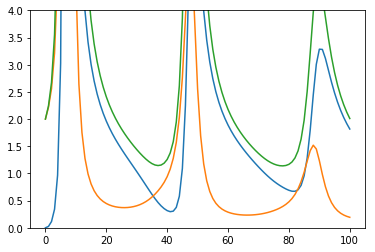

[[ 0.39113318+0.12542081j -0.08634152-0.13003167j -0.        +0.j        ]]


In [387]:
ref = [];
trans = []
wvlen_scan = np.linspace(1, 4, 20);
thickness = 0.5; # 1 layer
for scale in np.linspace(0,1,101):
    for wvlen in wvlen_scan[0:1]:
        k0 = 2*np.pi/wvlen;
        kx = np.sin(theta)*np.cos(phi);
        ky = np.sin(theta)*np.sin(phi);

        kxx=kx
        kyy=ky

        a11 = -1j*(kyy*mu_tensor[1,2]/mu_tensor[2,2] + kxx*(epsilon_tensor[2,0]/epsilon_tensor[2,2]))
        a12 = 1j*kxx*(mu_tensor[1,2]/mu_tensor[2,2] - epsilon_tensor[2,1]/epsilon_tensor[2,2]);
        a13 = kxx*kyy/epsilon_tensor[2,2] + mu_tensor[1,0] - mu_tensor[1,2]*mu_tensor[2,0]/mu_tensor[2,2];
        a14 = -kxx**2/epsilon_tensor[2,2] + mu_tensor[1,1]-  mu_tensor[1,2]*mu_tensor[2,1]/mu_tensor[2,2];

        a21 = 1j* kyy *(mu_tensor[0,2]/mu_tensor[2,2] - epsilon_tensor[2,0]/epsilon_tensor[2,2]);
        a22 = -1j * kxx*(mu_tensor[0,2]/mu_tensor[2,2]) +kyy *(epsilon_tensor[2,1]/epsilon_tensor[2,2]);
        a23 = kyy**2/epsilon_tensor[2,2] - mu_tensor[0,0] +  mu_tensor[0,2]*mu_tensor[2,0]/mu_tensor[2,2];
        a24 =  -kxx*kyy/epsilon_tensor[2,2] - mu_tensor[0,1] + mu_tensor[0,2]*mu_tensor[2,1]/mu_tensor[2,2];

        a31 = (kxx*kyy/mu_tensor[2,2] + epsilon_tensor[1,0] - epsilon_tensor[1,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2])
        a32 = (-kxx**2/mu_tensor[2,2] +epsilon_tensor[1,1] - epsilon_tensor[1,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2]);
        a33 = -1j*(kyy*(epsilon_tensor[1,2]/epsilon_tensor[2,2])+kxx*(mu_tensor[2,0]/mu_tensor[2,2]));
        a34 = 1j*kxx*(epsilon_tensor[1,2]/epsilon_tensor[2,2]-mu_tensor[2,1]/mu_tensor[2,2] )

        a41 = kyy**2/mu_tensor[2,2] - epsilon_tensor[0,0] +  epsilon_tensor[0,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2];
        a42 = -kxx*kyy/mu_tensor[2,2] - epsilon_tensor[0,1] + epsilon_tensor[0,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2];
        a43 = 1j*kyy*(epsilon_tensor[0,2]/epsilon_tensor[2,2]-mu_tensor[2,0]/mu_tensor[2,2] );
        a44 = -1j*(kxx*(epsilon_tensor[0,2]/epsilon_tensor[2,2])+kyy*(mu_tensor[2,1]/mu_tensor[2,2]));


        A = np.matrix([[a11, a12, a13, a14],
                      [a21, a22, a23, a24],
                      [a31, a32, a33, a34],
                      [a41, a42, a43, a44]]);

        #print(np.linalg.cond(A))
        eigenvals, eigenmodes = np.linalg.eig(A);
        rounded_eigenvals = np.round(eigenvals, 3)


        #print(np.round(eigenvals,3)); print(np.round(eigenmodes,3))

        ## suppose we directly diagonalize this matrix.


        ## we need to siphon off the forward propagating modes.
        sorted_eigs, sorted_inds = nonHermitianEigenSorter(np.round(eigenvals,10));
    #     sorted_inds = [1,3];
    #     sorted_eigs = eigenvals[sorted_inds];
        #print(sorted_eigs) ## since we have Ey, Ex, Hy, Hx, on a uniform slab, there is a 2-fold degeneracy 

    #     plt.plot(np.real(rounded_eigenvals), np.imag(rounded_eigenvals), 'o')
    #     plt.plot(np.real(sorted_eigs), np.imag(sorted_eigs), '.r')
    #     plt.show()

        ## ========================================================
        W_i = eigenmodes[0:2, sorted_inds];
        V_i = eigenmodes[2:, sorted_inds];
        Om =  np.matrix(np.diag(sorted_eigs) );
        #print(np.round(W_i,3), np.round(V_i,3), np.round(Om,3))

        #then what... match boundary conditions... try using the gaylord formulation.
        # or use the scattering matrix formalism, where we still, technically deal with all field components...

        Sg11 = np.matrix(np.zeros((2, 2))); Sg12 = np.matrix(np.eye(2, 2));
        Sg21 = np.matrix(np.eye(2, 2)); Sg22 = np.matrix(np.zeros((2, 2)));  # matrices
        Sg = np.block([[Sg11, Sg12], [Sg21, Sg22]]);  # initialization is equivelant as that for S_reflection side matrix

        ### ================= Working on the Reflection Side =========== ##
        Pr, Qr, kzr = pq.P_Q_kz(kx, ky, e_r, m_r)

        ## ============== values to keep track of =======================##
        S_matrices = list();
        kz_storage = [kzr];
        X_storage = list();
        ## ==============================================================##

        # define vacuum wavevector k0
        lam0 = wvlen;  # k0 and lam0 are related by 2*pi/lam0 = k0
        k0 = 2*np.pi/lam0;
        ## modes of the layer
        Om_r = np.matrix(cmath.sqrt(-1) * kzr * I);
        X_storage.append(Om_r);
        W_ref = I;
        V_ref = Qr * Om_r.I;  # can't play games with V like with W because matrices for V are complex
        #print(Om_r)
        ## calculating A and B matrices for scattering matrix
        Ar, Br = sm.A_B_matrices(Wg, W_ref, Vg, V_ref);

        S_ref, Sr_dict = sm.S_R(Ar, Br);  # scatter matrix for the reflection region
        S_matrices.append(S_ref);
        Sg, D_r, F_r = rs.RedhefferStar(Sg, S_ref);

        # longitudinal k_vector
        ## ============ WORKING INSIDE ANISOTROPIC LAYER ================#
        # now defIne A and B
        A, B = sm.A_B_matrices(Wg, W_i, Vg, V_i);

        # calculate scattering matrix
        S_layer, Sl_dict = sm.S_layer(A, B, thickness, k0*scale, Om)
        S_matrices.append(S_layer);

        ## update global scattering matrix using redheffer star
        Sg, D_i, F_i = rs.RedhefferStar(Sg, S_layer);

        ##========= Working on the Transmission Side==============##
        Pt, Qt, kz_trans = pq.P_Q_kz(kx, ky, e_t, m_t);
        kz_storage.append(kz_trans);

        Omt = cmath.sqrt(-1) * kz_trans * I;
        Vt = Qt * np.linalg.inv(Omt);

        # get At, Bt
        At, Bt = sm.A_B_matrices(Wg, I, Vg, Vt)

        ST, ST_dict = sm.S_T(At, Bt)
        S_matrices.append(ST);
        # update global scattering matrix
        Sg, D_t, F_t = rs.RedhefferStar(Sg, ST);

        K_inc_vector = n_i * k0 * np.matrix([np.sin(theta) * np.cos(phi), \
                                             np.sin(theta) * np.sin(phi), np.cos(theta)]);

        # cinc is the c1+
        E_inc, cinc, Polarization = ic.initial_conditions(K_inc_vector, theta, normal_vector, pte, ptm)

        ## COMPUTE FIELDS
        Er = Sg[0:2, 0:2] * cinc;  # S11; #(cinc = initial mode amplitudes), cout = Sg*cinc; #2d because Ex, Ey...
        Et = Sg[2:, 0:2] * cinc;  # S21

        Er = np.squeeze(np.asarray(Er));
        Et = np.squeeze(np.asarray(Et));

        Erx = Er[0];  Ery = Er[1]; Etx = Et[0]; Ety = Et[1];

        # apply the grad(E) = 0 equation to get z components, this equation comes out of the longitudinal equation 
        # or the divergence equation and is valid since the transmission region is VACUUM (as is the reflection region)
        Erz = -(kx * Erx + ky * Ery) / kzr;
        Etz = -(kx * Etx + ky * Ety) / kz_trans;  ## using divergence of E equation here

    #     Erz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Erx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ery) / kzr/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);
    #     Etz = -((epsilon_tensor[0,0]+epsilon_tensor[1,0]+epsilon_tensor[2,0])*kx * Etx + (epsilon_tensor[0,1]+epsilon_tensor[1,1]+epsilon_tensor[2,1])*ky * Ety) / kz_trans/(epsilon_tensor[0,2]+epsilon_tensor[1,2]+epsilon_tensor[2,2]);  ## using divergence of E equation here
#         Erz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kzr) * Erx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kzr)* Ery) /(epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kzr);
#         Etz = -((epsilon_tensor[0,0]*kx+epsilon_tensor[1,0]*ky+epsilon_tensor[2,0]*kz_trans) * Etx + (epsilon_tensor[0,1]*kx+epsilon_tensor[1,1]*ky+epsilon_tensor[2,1]*kz_trans)* Ety) / (epsilon_tensor[0,2]*kx+epsilon_tensor[1,2]*ky+epsilon_tensor[2,2]*kz_trans);  ## using divergence of E equation here

#         print(kx,ky,kzr,kz_trans)

        # add in the Erz component to vectors
        Er = np.matrix([Erx, Ery, Erz]);  # a vector
        Et = np.matrix([Etx, Ety, Etz]);
#         print(E_inc)

        R = np.linalg.norm(Er) ** 2;
        T = np.linalg.norm(Et) ** 2;
        ref.append(R);
        trans.append(T);
ref = np.array(ref);
trans = np.array(trans)
plt.plot(ref);
plt.plot(trans);
plt.plot(ref+trans)
plt.ylim([0,4])
plt.show()
print(Et)

In [388]:
np.where(np.abs(ref+trans-2)<1e-1)

(array([  0,  23,  24,  43,  61,  62,  85, 100]),)

## benchmarking against the usual tmm

In [43]:
test=np.matrix('1,1,0,1;1,1,0,0;0,0,1,0;1,1,0,1')

In [44]:
test

matrix([[1, 1, 0, 1],
        [1, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 1, 0, 1]])

In [45]:
np.linalg.eig(test)

(array([ 2.61803399e+00, -3.12904135e-16,  3.81966011e-01,  1.00000000e+00]),
 matrix([[ 6.47936163e-01,  7.07106781e-01,  4.65341127e-01,
           0.00000000e+00],
         [ 4.00446571e-01, -7.07106781e-01, -7.52937760e-01,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00],
         [ 6.47936163e-01, -1.91290791e-16,  4.65341127e-01,
           0.00000000e+00]]))

In [46]:
test2=np.matrix('1,1,1;1,1,1;1,1,1')

In [47]:
test2

matrix([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])

In [48]:
np.linalg.eig(test2)

(array([ 3.00000000e+00,  6.16297582e-33, -7.50963641e-17]),
 matrix([[ 5.77350269e-01, -6.51147040e-17,  6.09781659e-01],
         [ 5.77350269e-01, -7.07106781e-01, -7.75129861e-01],
         [ 5.77350269e-01,  7.07106781e-01,  1.65348202e-01]]))

In [51]:
test=np.matrix('1,0,1,1;0,1,0,0;1,0,1,1;1,0,1,1')

In [53]:
test

matrix([[1, 0, 1, 1],
        [0, 1, 0, 0],
        [1, 0, 1, 1],
        [1, 0, 1, 1]])

In [52]:
np.linalg.eig(test)

(array([ 3.00000000e+00,  6.16297582e-33, -7.50963641e-17,  1.00000000e+00]),
 matrix([[ 5.77350269e-01, -6.51147040e-17,  6.09781659e-01,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00],
         [ 5.77350269e-01,  7.07106781e-01,  1.65348202e-01,
           0.00000000e+00],
         [ 5.77350269e-01, -7.07106781e-01, -7.75129861e-01,
           0.00000000e+00]]))

In [68]:
the=np.pi/4*1
test=np.matrix([[0,np.exp(1j*the)],[np.exp(-1j*the),0]])

In [69]:
np.linalg.eig(test)

(array([ 1.-5.04378831e-17j, -1.+5.04378831e-17j]),
 matrix([[ 0.70710678+0.j ,  0.70710678+0.j ],
         [ 0.5       -0.5j, -0.5       +0.5j]]))

# TBG

In [5]:
from cmath import cos,sin,sqrt
from numpy.linalg import solve as bslash
pi=np.pi

In [6]:

theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);
sigmax=np.array([[0,1],[1,0]]);
sigmay=np.array([[0,-1j],[1j,0]]);
sigmaz=np.array([[1,0],[0,-1]]);
w=110;
vf=610;

In [8]:

theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);
G1=q2-q3;
G2=q2-q1;
sigmax=np.array([[0,1],[1,0]]);
sigmay=np.array([[0,-1j],[1j,0]]);
sigmaz=np.array([[1,0],[0,-1]]);
w=110;
vf=610;

In [117]:
def ham(k):
    k1=bslash(Rot,k)
    k2=Rot@(k-q1)
    k3=Rot@(k-q2)
    k4=Rot@(k-q3)
#     print(k1,k2,k3,k4)
    ham=np.matrix(np.zeros([8,8],dtype=np.complex))
    ham[:2,:2] = vf*k1[0]*sigmax-vf*k1[1]*sigmay
    ham[2:4,2:4] = vf*k2[0]*sigmax-vf*k2[1]*sigmay
    ham[4:6,4:6] = vf*k3[0]*sigmax-vf*k3[1]*sigmay
    ham[6:8,6:8] = vf*k4[0]*sigmax-vf*k4[1]*sigmay
    ham[0:2,2:4] = w*(np.eye(2)+sigmax)
    ham[2:4,0:2] = w*(np.eye(2)+sigmax)
    ham[0:2,4:6] = w*(np.eye(2)-1/2*sigmax-sqrt(3)/2*sigmay)
    ham[4:6,0:2] = w*(np.eye(2)-1/2*sigmax-sqrt(3)/2*sigmay)
    ham[0:2,6:8] = w*(np.eye(2)-1/2*sigmax+sqrt(3)/2*sigmay)
    ham[6:8,0:2] = w*(np.eye(2)-1/2*sigmax+sqrt(3)/2*sigmay)
    return ham

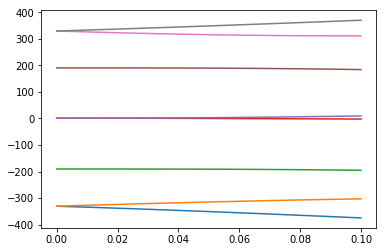

In [126]:
wses=[]
kxs=np.linspace(0,0.1,10)
for kx in kxs:
    k=np.array([[kx],[0]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
    plt.plot(kxs,i)

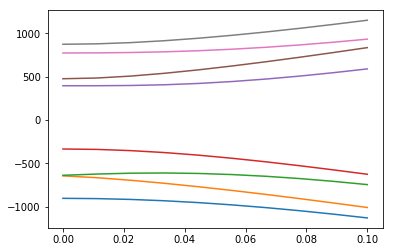

In [132]:
wses=[]
kys=np.linspace(0,1,10)
for ky in kys:
    k=np.array([[1],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
    plt.plot(kxs,i)

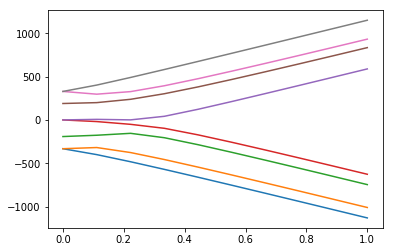

In [134]:
wses=[]
kxs=np.linspace(0,1,10)
for kx in kxs:
    k=np.array([[kx],[kx]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
    plt.plot(kxs,i)

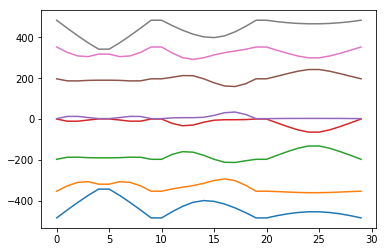

In [151]:
theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);

wses=[]
# kys=np.linspace(-0.312,0.312,10)
# for ky in kys:
#     k=np.array([[0],[ky]])
#     tmp=ham(k)
# #     print(tmp==np.matrix(tmp).H)
# #     print(tmp)
# #     print(np.linalg.eigh(tmp)[0])
#     wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(-q1[0],q1[0],10)
kys=np.linspace(-q1[1],q1[1],10)
# for ky in kys:
for i in range(10):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])    

kxs=np.linspace(q1[0],q2[0],10)
kys=np.linspace(q1[1],q2[1],10)
# for ky in kys:
for i in range(10):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(q2[0],-q1[0],10)
kys=np.linspace(q2[1],-q1[1],10)
# for ky in kys:
for i in range(10):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
#     plt.plot(kys,i)
    plt.plot(i)

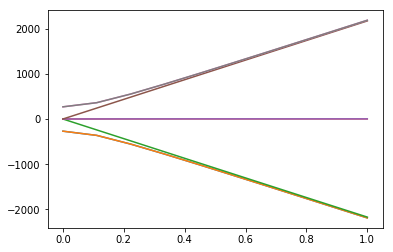

In [154]:
wses=[]
kxs=np.linspace(0,1,10)
thetas=np.linspace(0,12,10)*pi/180
for the in thetas:
    theta=the
    a0=0.246
    Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
    q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
    q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
    q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);
    k=np.array([[0],[0]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
    plt.plot(kxs,i)

In [139]:
print(q1)

[[ 0.        +0.j]
 [-0.31204275+0.j]]


In [145]:
print(theta/pi*180)

1.05


In [ ]:
wses=[]
kxs=np.linspace(0,0.1,10)
for kx in kxs:
    k=np.array([[kx],[0]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
    plt.plot(kxs,i)

In [128]:
vf*1*sigmax-vf*2*sigmay

array([[  0.   +0.j, 610.+1220.j],
       [610.-1220.j,   0.   +0.j]])

In [488]:
import pickle
with open('ham0m1.pkl', 'rb') as fin :
    ham0m1 = pickle.load(fin) 

import pickle
with open('ham0m0.pkl', 'rb') as fin :
    ham0m0 = pickle.load(fin) 

In [485]:
import os
import pandas as pd
cwd = os.getcwd()


In [486]:
def show(data):
    toshow=pd.DataFrame(np.around(data,3))
    display(toshow)

In [489]:
show(ham0m0)

0    1      2      3
0  0.0  0.0  0.000  0.000
1  0.0  0.0  0.000  0.000
2  0.0  0.0  0.000 -1.744
3  0.0  0.0 -1.744 -0.000

In [494]:
M=1
N=(2*M+1)*(2*M+1)*4
for i in range(1,2*M+1):
    for j in range(0,2*M):
        ind=4*((2*M+1)*i+j)+1;
        ind2=4*((2*M+1)*i+j+1)+1;
        ind3=4*((2*M+1)*(i-1)+j+1)+1;
        print("ind",ind,"ind2",ind2,"ind3",ind3)

ind 13 ind2 17 ind3 5
ind 17 ind2 21 ind3 9
ind 25 ind2 29 ind3 17
ind 29 ind2 33 ind3 21


In [496]:
M=1
N=(2*M+1)*(2*M+1)*4
for i in range(0,1):
    for j in range(0,2*M):
        ind=4*((2*M+1)*i+j)+1;
        ind2=4*((2*M+1)*i+j+1)+1;
        print("ind",ind,"ind2",ind2)

ind 1 ind2 5
ind 5 ind2 9


In [497]:
M=1
N=(2*M+1)*(2*M+1)*4
for i in range(0,2*M+1):
    for j in range(2*M,2*M+1):
        ind=4*((2*M+1)*i+j)+1;
        print("ind",ind)

ind 9
ind 21
ind 33


In [502]:

theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);
G1=q2-q3;
G2=q2-q1;
sigmax=np.array([[0,1],[1,0]]);
sigmay=np.array([[0,-1j],[1j,0]]);
sigmaz=np.array([[1,0],[0,-1]]);
w=110;
vf=610;

In [ ]:
def ham(k):
    k1=bslash(Rot,k)
    k2=Rot@(k-q1)
    k3=Rot@(k-q2)
    k4=Rot@(k-q3)
#     print(k1,k2,k3,k4)
    ham=np.matrix(np.zeros([8,8],dtype=np.complex))
    ham[:2,:2] = vf*k1[0]*sigmax-vf*k1[1]*sigmay
    ham[2:4,2:4] = vf*k2[0]*sigmax-vf*k2[1]*sigmay
    ham[4:6,4:6] = vf*k3[0]*sigmax-vf*k3[1]*sigmay
    ham[6:8,6:8] = vf*k4[0]*sigmax-vf*k4[1]*sigmay
    ham[0:2,2:4] = w*(np.eye(2)+sigmax)
    ham[2:4,0:2] = w*(np.eye(2)+sigmax)
    ham[0:2,4:6] = w*(np.eye(2)-1/2*sigmax-sqrt(3)/2*sigmay)
    ham[4:6,0:2] = w*(np.eye(2)-1/2*sigmax-sqrt(3)/2*sigmay)
    ham[0:2,6:8] = w*(np.eye(2)-1/2*sigmax+sqrt(3)/2*sigmay)
    ham[6:8,0:2] = w*(np.eye(2)-1/2*sigmax+sqrt(3)/2*sigmay)
    return ham

In [585]:
### nonperiodic BC
def ham(k,M=5):
#     print(k1,k2,k3,k4)
    NM=(2*M+1)*(2*M+1)
    ham=np.matrix(np.zeros([4*NM,4*NM],dtype=np.complex))
    ind=0
    ind2=0
    ind3=0
    for r in range(-M,M+1):
        for c in range(-M,M+1):
            k1=bslash(Rot,k-c*G1-r*G2)
            k2=Rot@(k-q1-c*G1-r*G2)
            ir,ic = r+M,c+M
            ind=(ir*(2*M+1)+ic)*4
            ham[ind:ind+2,ind:ind+2] = vf*k1[0]*sigmax-vf*k1[1]*sigmay
            ham[ind+2:ind+4,ind+2:ind+4] = vf*k2[0]*sigmax-vf*k2[1]*sigmay
            ham[ind:ind+2,ind+2:ind+4] = w*(np.eye(2)+sigmax)
            ham[ind+2:ind+4,ind:ind+2] = w*(np.eye(2)+sigmax)
            ### periodic B.C., hope doesn't matter at converging limit
#             ind2=(ind+(2*M+1)*4)%(4*NM) 
#             ind3=((ind-4)%(4*(2*M+1))+(2*M+1)*4)%(4*NM)
            if ((ir+1)*(2*M+1)+ic)*4<(4*NM):
                ind2=((ir+1)*(2*M+1)+ic)*4%(4*NM)
                ham[ind:ind+2,ind2+2:ind2+4] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)
                ham[ind2+2:ind2+4,ind:ind+2] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)
            if ((ir+1)*(2*M+1)+(ic-1)%(2*M+1))*4<(4*NM) and (ic-1)>=0:
                ind3=((ir+1)*(2*M+1)+(ic-1)%(2*M+1))*4%(4*NM)
                ham[ind:ind+2,ind3+2:ind3+4] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
                ham[ind3+2:ind3+4,ind:ind+2] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
            print('ind',ind,'ind2',ind2,'ind3',ind3)
#     return ham
ham(0,M=1)

ind 0 ind2 12 ind3 0
ind 4 ind2 16 ind3 12
ind 8 ind2 20 ind3 16
ind 12 ind2 24 ind3 16
ind 16 ind2 28 ind3 24
ind 20 ind2 32 ind3 28
ind 24 ind2 32 ind3 28
ind 28 ind2 32 ind3 28
ind 32 ind2 32 ind3 28


In [593]:
### nonperiodic BC, more correct
def ham(k,M=10):
#     print(k1,k2,k3,k4)
    NM=(2*M+1)*(2*M+1)
    ham=np.matrix(np.zeros([4*NM,4*NM],dtype=np.complex))
    ind2=0
    ind3=0
    for r in range(-M,M+1):
        for c in range(-M,M+1):
            k1=bslash(Rot,k-c*G1-r*G2)
            k2=Rot@(k-q1-c*G1-r*G2)
            ir,ic = r+M,c+M
            ind=(ir*(2*M+1)+ic)*4
            ham[ind:ind+2,ind:ind+2] = vf*k1[0]*sigmax-vf*k1[1]*sigmay
            ham[ind+2:ind+4,ind+2:ind+4] = vf*k2[0]*sigmax-vf*k2[1]*sigmay
            ham[ind:ind+2,ind+2:ind+4] = w*(np.eye(2)+sigmax)
            ham[ind+2:ind+4,ind:ind+2] = w*(np.eye(2)+sigmax)
            if r<M:
                ind2 = ((ir+1)*(2*M+1)+ic)*4
                ham[ind+2:ind+4,ind2:ind2+2] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)
                ham[ind2:ind2+2,ind+2:ind+4] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)
                if c>-M:
                    ind3 = ((ir+1)*(2*M+1)+ic-1)*4
                    ham[ind+2:ind+4,ind3:ind3+2] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
                    ham[ind3:ind3+2,ind+2:ind+4] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
#             print('ind',ind,'ind2',ind2,'ind3',ind3)
    return ham
# ham(0,M=1)

In [23]:
### nonperiodic BC, same index as Xiaoqi
def ham(k,M=1):
    arb=np.exp(1j*1.2)
#     print(k1,k2,k3,k4)
    NM=(2*M+1)*(2*M+1)
    ham=np.matrix(np.zeros([4*NM,4*NM],dtype=np.complex))
    ind2=0
    ind3=0
    for r in range(-M,M+1):
        for c in range(-M,M+1):
            k1=bslash(Rot,k-r*G1-c*G2)
            k2=Rot@(k-q1-r*G1-c*G2)
            ir,ic = r+M,c+M
            ind=(ir*(2*M+1)+ic)*4
            ham[ind:ind+2,ind:ind+2] = vf*k1[0]*sigmax-vf*k1[1]*sigmay
            ham[ind+2:ind+4,ind+2:ind+4] = vf*k2[0]*sigmax-vf*k2[1]*sigmay
            ham[ind:ind+2,ind+2:ind+4] = w*(np.eye(2)+sigmax)
            ham[ind+2:ind+4,ind:ind+2] = w*(np.eye(2)+sigmax)
            if c<M:
                ind2 = (ir*(2*M+1)+ic+1)*4
                ham[ind:ind+2,ind2+2:ind2+4] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)*arb
                ham[ind2+2:ind2+4,ind:ind+2] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)*np.conjugate(arb)
                if r>-M:
                    ind3 = ((ir-1)*(2*M+1)+ic+1)*4
                    ham[ind:ind+2,ind3+2:ind3+4] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
                    ham[ind3+2:ind3+4,ind:ind+2] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
#             print('ind',ind,'ind2',ind2,'ind3',ind3,r,c,k1,k2)
    return ham
# ham(0,M=1)

In [613]:
Rot


array([[ 0.99995802-0.j, -0.00916285-0.j],
       [ 0.00916285+0.j,  0.99995802-0.j]])

In [572]:
### periodic BC
def ham(k,M=5):
#     print(k1,k2,k3,k4)
    NM=(2*M+1)*(2*M+1)
    ham=np.matrix(np.zeros([4*NM,4*NM],dtype=np.complex))
    for r in range(-M,M+1):
        for c in range(-M,M+1):
            k1=bslash(Rot,k-c*G1-r*G2)
            k2=Rot@(k-q1-c*G1-r*G2)
            ir,ic = r+M,c+M
            ind=(ir*(2*M+1)+ic)*4
            ham[ind:ind+2,ind:ind+2] = vf*k1[0]*sigmax-vf*k1[1]*sigmay
            ham[ind+2:ind+4,ind+2:ind+4] = vf*k2[0]*sigmax-vf*k2[1]*sigmay
            ham[ind:ind+2,ind+2:ind+4] = w*(np.eye(2)+sigmax)
            ham[ind+2:ind+4,ind:ind+2] = w*(np.eye(2)+sigmax)
            ### periodic B.C., hope doesn't matter at converging limit
#             ind2=(ind+(2*M+1)*4)%(4*NM) 
#             ind3=((ind-4)%(4*(2*M+1))+(2*M+1)*4)%(4*NM)
            ind2=((ir+1)*(2*M+1)+ic)*4%(4*NM)
            ind3=((ir+1)*(2*M+1)+(ic-1)%(2*M+1))*4%(4*NM)
            ham[ind:ind+2,ind2+2:ind2+4] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)
            ham[ind2+2:ind2+4,ind:ind+2] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)
            ham[ind:ind+2,ind3+2:ind3+4] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
            ham[ind3+2:ind3+4,ind:ind+2] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
#             print('ind',ind,'ind2',ind2,'ind3',ind3)
    return ham

In [539]:
ham(0,1)

matrix([[   0.          +0.j        ,  497.12901863+280.97578944j,
          110.          +0.j        , ...,    0.          +0.j        ,
            0.          +0.j        ,    0.          +0.j        ],
        [ 497.12901863-280.97578944j,    0.          +0.j        ,
          110.          +0.j        , ...,    0.          +0.j        ,
            0.          +0.j        ,    0.          +0.j        ],
        [ 110.          +0.j        ,  110.          +0.j        ,
            0.          +0.j        , ...,    0.          +0.j        ,
            0.          +0.j        ,    0.          +0.j        ],
        ...,
        [   0.          +0.j        ,    0.          +0.j        ,
            0.          +0.j        , ...,    0.          +0.j        ,
          110.          +0.j        ,  110.          +0.j        ],
        [   0.          +0.j        ,    0.          +0.j        ,
            0.          +0.j        , ...,  110.          +0.j        ,
            0.      

(-200, 200)

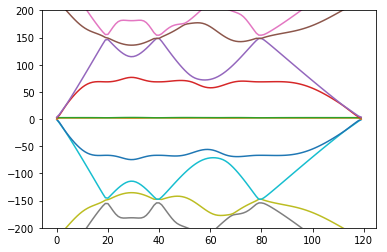

In [548]:
theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);

numk=40
wses=[]
# kys=np.linspace(-0.312,0.312,10)
# for ky in kys:
#     k=np.array([[0],[ky]])
#     tmp=ham(k)
# #     print(tmp==np.matrix(tmp).H)
# #     print(tmp)
# #     print(np.linalg.eigh(tmp)[0])
#     wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(-q1[0],q1[0],numk)
kys=np.linspace(-q1[1],q1[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])    

kxs=np.linspace(q1[0],q2[0],numk)
kys=np.linspace(q1[1],q2[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(q2[0],-q1[0],numk)
kys=np.linspace(q2[1],-q1[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
#     plt.plot(kys,i)
    plt.plot(i)
plt.ylim([-200,200])

(-200, 200)

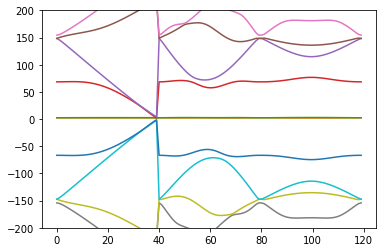

In [549]:
theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);

numk=40
wses=[]
# kys=np.linspace(-0.312,0.312,10)
# for ky in kys:
#     k=np.array([[0],[ky]])
#     tmp=ham(k)
# #     print(tmp==np.matrix(tmp).H)
# #     print(tmp)
# #     print(np.linalg.eigh(tmp)[0])
#     wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(0,-q1[0]*2,2*numk)
kys=np.linspace(0,-q1[1]*2,2*numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])    

kxs=np.linspace(-q1[0]*2,q2[0],numk)
kys=np.linspace(-q1[1]*2,q2[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(q2[0],0,numk)
kys=np.linspace(q2[1],0,numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
#     plt.plot(kys,i)
    plt.plot(i)
plt.ylim([-200,200])

(-200, 200)

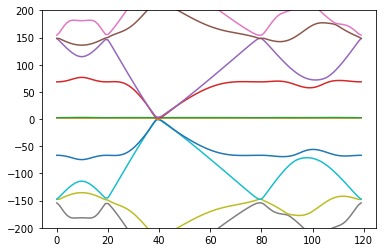

In [550]:
theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);

numk=40
wses=[]
# kys=np.linspace(-0.312,0.312,10)
# for ky in kys:
#     k=np.array([[0],[ky]])
#     tmp=ham(k)
# #     print(tmp==np.matrix(tmp).H)
# #     print(tmp)
# #     print(np.linalg.eigh(tmp)[0])
#     wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(q1[0],-q1[0],numk)
kys=np.linspace(q1[1],-q1[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])    

kxs=np.linspace(-q1[0],q2[0],numk)
kys=np.linspace(-q1[1],q2[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(q2[0],q1[0],numk)
kys=np.linspace(q2[1],q1[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
#     plt.plot(kys,i)
    plt.plot(i)
plt.ylim([-200,200])

(-200, 200)

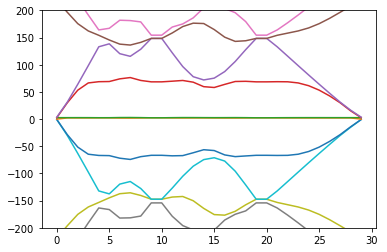

In [537]:
theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);

wses=[]
# kys=np.linspace(-0.312,0.312,10)
# for ky in kys:
#     k=np.array([[0],[ky]])
#     tmp=ham(k)
# #     print(tmp==np.matrix(tmp).H)
# #     print(tmp)
# #     print(np.linalg.eigh(tmp)[0])
#     wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(-q1[0],q1[0],10)
kys=np.linspace(-q1[1],q1[1],10)
# for ky in kys:
for i in range(10):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])    

kxs=np.linspace(q1[0],q2[0],10)
kys=np.linspace(q1[1],q2[1],10)
# for ky in kys:
for i in range(10):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(q2[0],-q1[0],10)
kys=np.linspace(q2[1],-q1[1],10)
# for ky in kys:
for i in range(10):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
#     plt.plot(kys,i)
    plt.plot(i)
plt.ylim([-200,200])

In [565]:
theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])

for i in np.linspace(0,1,10):
    k=q1/2
    k1=bslash(Rot,k)
    k2=Rot@(k-q1)
    ham=np.matrix(np.zeros([4,4],dtype=np.complex))
    ham[:2,:2] = vf*k1[0]*sigmax-vf*k1[1]*sigmay
    ham[2:4,2:4] = vf*k2[0]*sigmax-vf*k2[1]*sigmay
    print(np.linalg.eig(ham))

(array([ 95.17303765+1.92213914e-15j, -95.17303765-1.92213914e-15j,
        95.17303765-1.92213914e-15j, -95.17303765+1.92213914e-15j]), matrix([[-0.00647911-0.7070771j,  0.70710678+0.j       ,
          0.        +0.j       ,  0.        -0.j       ],
        [ 0.70710678+0.j       ,  0.00647911-0.7070771j,
          0.        +0.j       ,  0.        -0.j       ],
        [ 0.        +0.j       , -0.        +0.j       ,
         -0.00647911+0.7070771j,  0.70710678+0.j       ],
        [ 0.        +0.j       , -0.        +0.j       ,
          0.70710678+0.j       ,  0.00647911+0.7070771j]]))


In [564]:
print(k1,'\n',k2)

[[ 0.        +0.j]
 [-0.15602137+0.j]] 
 [[0.        +0.j]
 [0.15602137+0.j]]


In [559]:
610*0.312

190.32

(-200, 200)

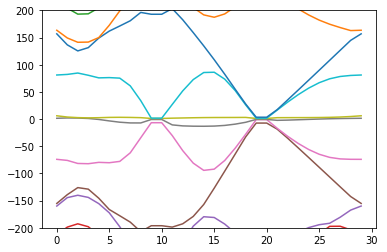

In [20]:
theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);

numk=10
wses=[]
# kys=np.linspace(-0.312,0.312,10)
# for ky in kys:
#     k=np.array([[0],[ky]])
#     tmp=ham(k)
# #     print(tmp==np.matrix(tmp).H)
# #     print(tmp)
# #     print(np.linalg.eigh(tmp)[0])
#     wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(q1[0],-q1[0],numk)
kys=np.linspace(q1[1],-q1[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])    

kxs=np.linspace(-q1[0],-q2[0],numk)
kys=np.linspace(-q1[1],-q2[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(-q2[0],q1[0],numk)
kys=np.linspace(-q2[1],q1[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
#     plt.plot(kys,i)
    plt.plot(i)
plt.ylim([-200,200])

(-200, 200)

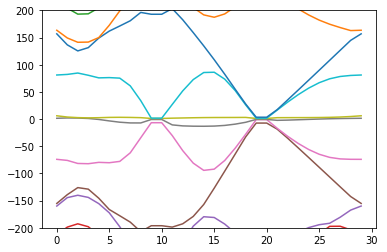

In [24]:
theta=pi*1.05/180;
a0=0.246
Rot=np.array([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
q1=8*pi/(3*a0)*sin(theta/2)*np.array([[0],[-1]]);
q2=8*pi/(3*a0)*sin(theta/2)*np.array([[sqrt(3)/2],[1/2]]);
q3=8*pi/(3*a0)*sin(theta/2)*np.array([[-sqrt(3)/2],[1/2]]);

numk=10
wses=[]
# kys=np.linspace(-0.312,0.312,10)
# for ky in kys:
#     k=np.array([[0],[ky]])
#     tmp=ham(k)
# #     print(tmp==np.matrix(tmp).H)
# #     print(tmp)
# #     print(np.linalg.eigh(tmp)[0])
#     wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(q1[0],-q1[0],numk)
kys=np.linspace(q1[1],-q1[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])    

kxs=np.linspace(-q1[0],-q2[0],numk)
kys=np.linspace(-q1[1],-q2[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])

kxs=np.linspace(-q2[0],q1[0],numk)
kys=np.linspace(-q2[1],q1[1],numk)
# for ky in kys:
for i in range(numk):
    kx=kxs[i]
    ky=kys[i]
    k=np.array([[kx],[ky]])
    tmp=ham(k)
#     print(tmp==np.matrix(tmp).H)
#     print(tmp)
#     print(np.linalg.eigh(tmp)[0])
    wses.append(np.linalg.eigh(tmp)[0])
# for i in wses:
wses=np.array(wses)
for i in wses.T:
#     plt.plot(kys,i)
    plt.plot(i)
plt.ylim([-200,200])

In [13]:
print(ham(k).shape)

(36, 36)


In [ ]:
### square lattice, nonperiodic BC, same index as Xiaoqi
def hamsq(k,M=5):
#     print(k1,k2,k3,k4)
    NM=(2*M+1)*(2*M+1)
    ham=np.matrix(np.zeros([4*NM,4*NM],dtype=np.complex))
    ind2=0
    ind3=0
    for r in range(-M,M+1):
        for c in range(-M,M+1):
            k1=bslash(Rot,k-r*G1-c*G2)
            k2=Rot@(k-q1-r*G1-c*G2)
            ir,ic = r+M,c+M
            ind=(ir*(2*M+1)+ic)*4
            ham[ind:ind+2,ind:ind+2] = vf*k1[0]*sigmax-vf*k1[1]*sigmay
            ham[ind+2:ind+4,ind+2:ind+4] = vf*k2[0]*sigmax-vf*k2[1]*sigmay
            ham[ind:ind+2,ind+2:ind+4] = w*(np.eye(2)+sigmax)
            ham[ind+2:ind+4,ind:ind+2] = w*(np.eye(2)+sigmax)
            if c<M:
                ind2 = (ir*(2*M+1)+ic+1)*4
                ham[ind:ind+2,ind2+2:ind2+4] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)
                ham[ind2+2:ind2+4,ind:ind+2] = w*(np.eye(2)-1.0/2*sigmax-sqrt(3)/2*sigmay)
                if r>-M:
                    ind3 = ((ir-1)*(2*M+1)+ic+1)*4
                    ham[ind:ind+2,ind3+2:ind3+4] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
                    ham[ind3+2:ind3+4,ind:ind+2] = w*(np.eye(2)-1.0/2*sigmax+sqrt(3)/2*sigmay)
#             print('ind',ind,'ind2',ind2,'ind3',ind3,r,c,k1,k2)
    return ham
# ham(0,M=1)

In [631]:
h=np.matrix([[0.9,1],[1,1.1]])
print(np.linalg.eig(h)[0])
print(np.linalg.eig(h)[0][0]-np.linalg.eig(h)[0][1],(np.linalg.eig(h)[0][0]+np.linalg.eig(h)[0][1])*0.5)

[-0.00498756  2.00498756]
-2.0099751242241783 1.0


In [625]:
h=np.matrix([[9,1],[1,11]])
print(np.linalg.eig(h)[0])
print(np.linalg.eig(h)[0][0]-np.linalg.eig(h)[0][1],(np.linalg.eig(h)[0][0]+np.linalg.eig(h)[0][1])*0.5)

[ 8.58578644 11.41421356]
-2.8284271247461916 10.0


In [626]:
h=np.matrix([[0.8,1],[1,1.2]])
print(np.linalg.eig(h)[0])
print(np.linalg.eig(h)[0][0]-np.linalg.eig(h)[0][1],(np.linalg.eig(h)[0][0]+np.linalg.eig(h)[0][1])*0.5)

[-0.0198039  2.0198039]
-2.0396078054371136 0.9999999999999999


In [627]:
h=np.matrix([[0.6,1],[1,1.4]])
print(np.linalg.eig(h)[0])
print(np.linalg.eig(h)[0][0]-np.linalg.eig(h)[0][1],(np.linalg.eig(h)[0][0]+np.linalg.eig(h)[0][1])*0.5)

[-0.07703296  2.07703296]
-2.1540659228538015 1.0


In [632]:
np.sqrt(0.2*0.2+4)

2.009975124224178